The MIT License (MIT)

Copyright (c) 2015 [David Rogers](http://www.doclrogers.com)

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
THE SOFTWARE.

Based off R code from Dr. Donald Brown

##### Honor Pledge: On my honor, I pledge that I am the sole author of this paper and I have accurately cited all help and references used in its completion.

### Import necessary libraries

This notebook could not have been made with out the [SciPy collection of libraries](http://www.scipy.org/stackspec.html#stackspec), [scikit-learn](http://scikit-learn.org/stable/), and [seaborn](http://stanford.edu/~mwaskom/software/seaborn/) \[1,2,3\].

In [1]:
# Data
import pandas as pd
import numpy as np
import scipy as sp

# Statistics
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve
import statsmodels.api as sm
import statsmodels.sandbox.tools.tools_pca as sm_pca
from statsmodels.formula.api import glm as sm_glm

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid", color_codes=True)

# Printing
import locale
locale.setlocale( locale.LC_ALL, '' )

%precision %.4g
pd.set_option('display.float_format', '{:.6g}'.format)

%matplotlib inline
# Ensure no errors occur

In [2]:
# Custom plot like uva.pairs in R
def pearsonr_plot(x, y, **kwargs):
    corr = np.corrcoef(x, y)[1][0]
    subplot = plt.gca()
    
    # Clear the plot
    subplot.cla()
    subplot.get_xaxis().set_visible(False)
    subplot.get_yaxis().set_visible(False)
    
    # Add in text for pearson R value
    subplot.text(0.5, 0.5, str(np.round(corr, 2)),
                 ha="center", va="center",
                 transform=subplot.transAxes,
                 size=40, color='black')

In [3]:
def convert_df_to_patsy_rhs_formula(data_frame):
    df_vars = np.rec.fromarrays([data_frame.columns, data_frame.dtypes.tolist()])
    
    formula = "("
    for item in df_vars:
        formula = formula + item[0] + '+ '
    
    # Replace last plus sign with close parenthese
    formula = formula.rstrip("+ ") + ")"
    
    # Return the formula
    return formula

In [4]:
# %load anova_glm.py
from statsmodels.compat.python import lrange, lmap
import numpy as np
import scipy as sp
import pandas as pd
from statsmodels.formula.formulatools import (_remove_intercept_patsy,
                                    _has_intercept, _intercept_idx)

def anova_glm(*args, **kwargs):
    """
    ANOVA table for one or more generalized linear models by Chi-Squared.
    
    Based off:
        https://github.com/statsmodels/statsmodels/blob/f3077577a983fc16217c77d98618510e7eebd66c/statsmodels/stats/anova.py
        https://svn.r-project.org/R/trunk/src/library/stats/R/anova.R
    """
    typ = kwargs.get('typ', 1)

    ### Farm Out Single model ANOVA Type I, II, III, and IV ###

    if len(args) == 1:
        model = args[0]
        return anova_single(model, **kwargs)

    try:
        assert typ in [1,"I"]
    except:
        raise ValueError("Multiple models only supported for type I. "
                         "Got type %s" % str(typ))

    ### COMPUTE ANOVA TYPE I ###

    # if given a single model
    if len(args) == 1:
        return anova_single(*args, **kwargs)

    # received multiple fitted models

    test = kwargs.get("test", "Chisq")
    scale = kwargs.get("scale", None)
    n_models = len(args)

    model_formula = []
    pr_test = "Pr(>%s)" % test
    names = ['df_resid', 'deviance', 'df_diff', 'deviance_diff', pr_test]
    table = pd.DataFrame(np.zeros((n_models, 5)), columns = names)

    if not scale: # assume biggest model is last
        scale = args[-1].scale

# From R implementation    
#    "Rao" = ,"LRT" = ,"Chisq" = {
#               dfs <- table[, "Df"]
#               vals <- table[, dev.col]/scale * sign(dfs)
#	            vals[dfs %in% 0] <- NA
#               vals[!is.na(vals) & vals < 0] <- NA # rather than p = 0
#	            cbind(table,
#                     "Pr(>Chi)" = pchisq(vals, abs(dfs), lower.tail = FALSE)
#                    )
#	   },
    
    table["deviance"] = lmap(getattr, args, ["deviance"]*n_models)
    table["df_resid"] = lmap(getattr, args, ["df_resid"]*n_models)
    table.ix[1:, "df_diff"] = -np.diff(table["df_resid"].values)
    table["deviance_diff"] = -table["deviance"].diff()
    
    if test == "Chisq":
        table[pr_test] = 1.0 - sp.stats.chi2.cdf(table["deviance_diff"]/scale, np.abs(table["df_diff"]).max())
        
    return table

Biplot code modified from original at [Biboroko](http://okomestudio.net/biboroku/?p=2292) \[4\].

In [5]:
# %load biplot.py
# Credits to: http://okomestudio.net/biboroku/?p=2292

import numpy as np

def biplot(plt, pca, labels=None, colors=None,
           xpc=1, ypc=2, scale=1, show_arrows=True, arrow_scale=25):
    """Generate biplot from the result of pcasvd of statsmodels.
    Parameters
    ----------
    plt : object
        An existing pyplot module reference.
    pca : tuple
        The result from statsmodels.sandbox.tools.tools_pca.pcasvd.
    labels : array_like, optional
        Labels for each observation.
    colors : array_like, optional
        Colors for each observation.
    xpc, ypc : int, optional
        The principal component number for x- and y-axis. Defaults to
        (xpc, ypc) = (1, 2).
    scale : float
        The variables are scaled by lambda ** scale, where lambda =
        singular value = sqrt(eigenvalue), and the observations are
        scaled by lambda ** (1 - scale). Must be in [0, 1].
    show_arrows : bool
    arrow_scale : float
    Returns
    -------
    None.
    """
    xpc, ypc = (xpc - 1, ypc - 1)
    xreduced, factors, evals, evecs = pca
    singvals = np.sqrt(evals)

    # data
    xs = factors[:, xpc] * singvals[xpc]**(1. - scale)
    ys = factors[:, ypc] * singvals[ypc]**(1. - scale)

    if labels is not None:
        for i, (t, x, y) in enumerate(zip(labels, xs, ys)):
            c = 'k' if colors is None else colors[i]
            plt.text(x, y, t, color=c, ha='center', va='center')
        xmin, xmax = xs.min(), xs.max()
        ymin, ymax = ys.min(), ys.max()
        xpad = (xmax - xmin) * 0.1
        ypad = (ymax - ymin) * 0.1
        plt.xlim(xmin - xpad, xmax + xpad)
        plt.ylim(ymin - ypad, ymax + ypad)
    else:
        colors = 'k' if colors is None else colors
        plt.scatter(xs, ys, c=colors, marker='.')

    # variables
    if show_arrows:
        tvars = np.dot(np.eye(factors.shape[0], factors.shape[1]),
                       evecs) * singvals**scale

        for i, col in enumerate(xreduced.columns.values):
            x, y = tvars[i][xpc], tvars[i][ypc]
            plt.arrow(0, 0, x*arrow_scale, y*arrow_scale, color='r',
                      width=0.01, head_width=0.05)
            plt.text(x*(arrow_scale+1), y*(arrow_scale+1), col, color='r', ha='center', va='center')

    plt.xlabel('PC{}'.format(xpc + 1))
    plt.ylabel('PC{}'.format(ypc + 1))


Forward Selected code modified from original at [PlanSpace](http://planspace.org/20150423-forward_selection_with_statsmodels/) [5].

In [6]:
# Credits to: http://planspace.org/20150423-forward_selection_with_statsmodels/
def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by BIC
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 999999, 999999
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response, ' + '.join(selected + [candidate]))
            score = sm_glm(formula, data, family=sm.families.Binomial()).fit().bic
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort(reverse=True)
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score > best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response, ' + '.join(selected))
    model = sm_glm(formula, data, family=sm.families.Binomial()).fit()
    return model

# 1 Problem Description

## 1.1 Situation

According to 'The Economics of Spam', Justin Rao of Microsoft Research and David
Reiley of Google Inc, conservatively estimate the cost of spam for American firms in 2012 to be $20 billion annually [6]. Additionally, the authors note the cost would be much higher if not for significant investment in anti-spam technologies. As a student in 'APMA 6430: Statistics for Engineers and Scientists' I am assigned to analyze and design a spam classifier [7]. I am provided with a template for this report and a data set from the  UCI Machine Learning Repository [8, 9].

## 1.2 Goal

The goal of this study is to identify a suitable spam filter and discuss the tradeoffs.

## 1.3 Metrics

The metrics for a spam classifier include the false positive and false negative rates. False positive are emails that are classified as spam when in fact the email is ham. Similarly, false negatives are emails classified as ham when they are in fact spam.

## 1.4 Hypothesis

The number of capital letters in an email is not a significant predictor of spam.

# 2 Approach

## 2.1 Data

In [7]:
# Read in the spam data
spam_df = pd.read_csv('../Data/Spam/Spam.txt', delimiter=' ', header=None)

In [8]:
# Summarize it; make sure it looks okay
spam_df.describe()

0        1        2         3        4         5        6   \
count     4601     4601     4601      4601     4601      4601     4601   
mean  0.104553 0.213015 0.280656 0.0654249 0.312223 0.0959009 0.114208   
std   0.305358  1.29058 0.504143   1.39515 0.672513  0.273824 0.391441   
min          0        0        0         0        0         0        0   
25%          0        0        0         0        0         0        0   
50%          0        0        0         0        0         0        0   
75%          0        0     0.42         0     0.38         0        0   
max       4.54    14.28      5.1     42.81       10      5.88     7.27   

            7         8        9    ...           48       49        50  \
count     4601      4601     4601   ...         4601     4601      4601   
mean  0.105295 0.0900674 0.239413   ...    0.0385747  0.13903 0.0169759   
std   0.401071  0.278616 0.644755   ...     0.243471 0.270355  0.109394   
min          0         0        0   ...            0        0         0   
25%          0         0        0   ...            0        0         0   
50%          0         0        0   ...            0    0.065         0   
75%          0         0     0.16   ...            0    0.188         0   
max      11.11      5.26    18.18   ...        4.385    9.752     4.081   

            51        52        53      54      55      56       57  
count     4601      4601      4601    4601    4601    4601     4601  
mean  0.269071 0.0758107 0.0442382 5.19152 52.1728 283.289 0.394045  
std   0.815672  0.245882  0.429342 31.7294 194.891 606.348 0.488698  
min          0         0         0       1       1       1        0  
25%          0         0         0   1.588       6      35        0  
50%          0         0         0   2.276      15      95        0  
75%      0.315     0.052         0   3.706      43     266        1  
max     32.478     6.003    19.829  1102.5    9989   15841        1  

[8 rows x 58 columns]

The data comes from the UCI Machine Learning Repository [9]. According to the curator of the data, 

```
Our collection of spam e-mails came from our postmaster and individuals who had filed spam. Our collection of non-spam e-mails came from filed work and personal e-mails, and hence the word 'george' and the area code '650' are indicators of non-spam [9].
```

The description of the data set is as follows:

```
The last column of 'spambase.data' denotes whether the e-mail was considered spam (1) or not (0), i.e. unsolicited commercial e-mail. Most of the attributes indicate whether a particular word or character was frequently occuring in the e-mail. The run-length attributes (55-57) measure the length of sequences of consecutive capital letters. For the statistical measures of each attribute, see the end of this file. Here are the definitions of the attributes: 

48 continuous real [0,100] attributes of type word_freq_WORD 
= percentage of words in the e-mail that match WORD, i.e. 100 * (number of times the WORD appears in the e-mail) / total number of words in e-mail. A "word" in this case is any string of alphanumeric characters bounded by non-alphanumeric characters or end-of-string. 

6 continuous real [0,100] attributes of type char_freq_CHAR] 
= percentage of characters in the e-mail that match CHAR, i.e. 100 * (number of CHAR occurences) / total characters in e-mail 

1 continuous real [1,...] attribute of type capital_run_length_average 
= average length of uninterrupted sequences of capital letters 

1 continuous integer [1,...] attribute of type capital_run_length_longest 
= length of longest uninterrupted sequence of capital letters 

1 continuous integer [1,...] attribute of type capital_run_length_total 
= sum of length of uninterrupted sequences of capital letters 
= total number of capital letters in the e-mail 

1 nominal {0,1} class attribute of type spam 
= denotes whether the e-mail was considered spam (1) or not (0), i.e. unsolicited commercial e-mail [9]. 
```

The names of the words and characters are provided via an [addendum](http://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.names) with the data [9].

In [9]:
# Let's reindex to make column indicies clearer based on description above 
# and a supplementary names file.
# See: http://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.names
spam_labels = []

spam_labels_words = ['MAKE', 'ADDRESS', 'ALL', '3D', 'OUR', 'OVER',
                     'REMOVE', 'INTERNET', 'ORDER', 'MAIL', 'RECEIVE',
                     'WILL', 'PEOPLE', 'REPORT', 'ADDRESSES', 'FREE',
                     'BUSINESS', 'EMAIL', 'YOU', 'CREDIT', 'YOUR',
                     'FONT', '000', 'MONEY', 'HP', 'HPL', 'GEORGE',
                     '650', 'LAB', 'LABS', 'TELNET', '857', 'DATA',
                     '415', '85', 'TECHNOLOGY', '1999', 'PARTS', 'PM',
                     'DIRECT', 'CS', 'MEETING', 'ORIGINAL', 'PROJECT',
                     'RE', 'EDU', 'TABLE', 'CONFERENCE']

for ii in xrange(0, 48):
    spam_labels.append('WORD_' + spam_labels_words[ii])

spam_labels_char = ['SEMICOLON', 'PAREN', 'BRACE', 'EXCLAMATION', 'DOLLAR', 'HASH']
for ii in xrange(0, 6):
    spam_labels.append('CHAR_' + spam_labels_char[ii])

spam_labels.append('CAPS_AVG')
spam_labels.append('CAPS_LONG')
spam_labels.append('CAPS_TOTAL')
spam_labels.append('TYPE')

print spam_labels
spam_df.columns = spam_labels

['WORD_MAKE', 'WORD_ADDRESS', 'WORD_ALL', 'WORD_3D', 'WORD_OUR', 'WORD_OVER', 'WORD_REMOVE', 'WORD_INTERNET', 'WORD_ORDER', 'WORD_MAIL', 'WORD_RECEIVE', 'WORD_WILL', 'WORD_PEOPLE', 'WORD_REPORT', 'WORD_ADDRESSES', 'WORD_FREE', 'WORD_BUSINESS', 'WORD_EMAIL', 'WORD_YOU', 'WORD_CREDIT', 'WORD_YOUR', 'WORD_FONT', 'WORD_000', 'WORD_MONEY', 'WORD_HP', 'WORD_HPL', 'WORD_GEORGE', 'WORD_650', 'WORD_LAB', 'WORD_LABS', 'WORD_TELNET', 'WORD_857', 'WORD_DATA', 'WORD_415', 'WORD_85', 'WORD_TECHNOLOGY', 'WORD_1999', 'WORD_PARTS', 'WORD_PM', 'WORD_DIRECT', 'WORD_CS', 'WORD_MEETING', 'WORD_ORIGINAL', 'WORD_PROJECT', 'WORD_RE', 'WORD_EDU', 'WORD_TABLE', 'WORD_CONFERENCE', 'CHAR_SEMICOLON', 'CHAR_PAREN', 'CHAR_BRACE', 'CHAR_EXCLAMATION', 'CHAR_DOLLAR', 'CHAR_HASH', 'CAPS_AVG', 'CAPS_LONG', 'CAPS_TOTAL', 'TYPE']


In [10]:
# Check for missing data
pd.isnull(spam_df).any()

WORD_MAKE           False
WORD_ADDRESS        False
WORD_ALL            False
WORD_3D             False
WORD_OUR            False
WORD_OVER           False
WORD_REMOVE         False
WORD_INTERNET       False
WORD_ORDER          False
WORD_MAIL           False
WORD_RECEIVE        False
WORD_WILL           False
WORD_PEOPLE         False
WORD_REPORT         False
WORD_ADDRESSES      False
WORD_FREE           False
WORD_BUSINESS       False
WORD_EMAIL          False
WORD_YOU            False
WORD_CREDIT         False
WORD_YOUR           False
WORD_FONT           False
WORD_000            False
WORD_MONEY          False
WORD_HP             False
WORD_HPL            False
WORD_GEORGE         False
WORD_650            False
WORD_LAB            False
WORD_LABS           False
WORD_TELNET         False
WORD_857            False
WORD_DATA           False
WORD_415            False
WORD_85             False
WORD_TECHNOLOGY     False
WORD_1999           False
WORD_PARTS          False
WORD_PM     

In [11]:
# Let's get some metrics
print spam_df.shape
print 'Total data points =', len(spam_df.index)
print 'Total spam =', len(spam_df[spam_df['TYPE'] == 1].index)
print 'Total ham =', len(spam_df[spam_df['TYPE'] == 0].index)
print 'Percentage spam =', len(spam_df[spam_df['TYPE'] == 0].index)/float(len(spam_df.index))*100 
print 'Percentage ham =', len(spam_df[spam_df['TYPE'] == 1].index)/float(len(spam_df.index))*100

(4601, 58)
Total data points = 4601
Total spam = 1813
Total ham = 2788
Percentage spam = 60.5955227125
Percentage ham = 39.4044772875


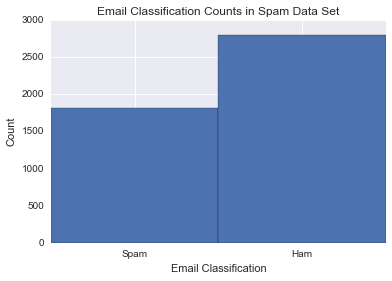

In [12]:
# Plot spam and ham counts
labels = ['Spam', 'Ham']
frequencies = [len(spam_df[spam_df['TYPE'] == 1].index), 
               len(spam_df[spam_df['TYPE'] == 0].index)]

pos = np.arange(len(labels))
width = 1.0
ax = plt.axes()
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(labels)

plt.bar(pos, frequencies, width, color='b')
plt.title('Email Classification Counts in Spam Data Set')
plt.xlabel('Email Classification')
plt.ylabel('Count')
plt.show()

In [13]:
# Highest percentage of a specific word in an email
max_percent_word = spam_df.ix[:,:48].max().max()
max_percent_word_col = spam_df.ix[:,:48].max().idxmax()
print spam_df.loc[spam_df[max_percent_word_col] == max_percent_word][max_percent_word_col]

1102   42.81
Name: WORD_3D, dtype: float64


The data set contains 4,601 entries with roughly a 3:2 ratio of spam to ham. No missing data was identifed. Each entry has all 57 data points as described above and a ground truth classification.

### Factor Plots for Spam Data

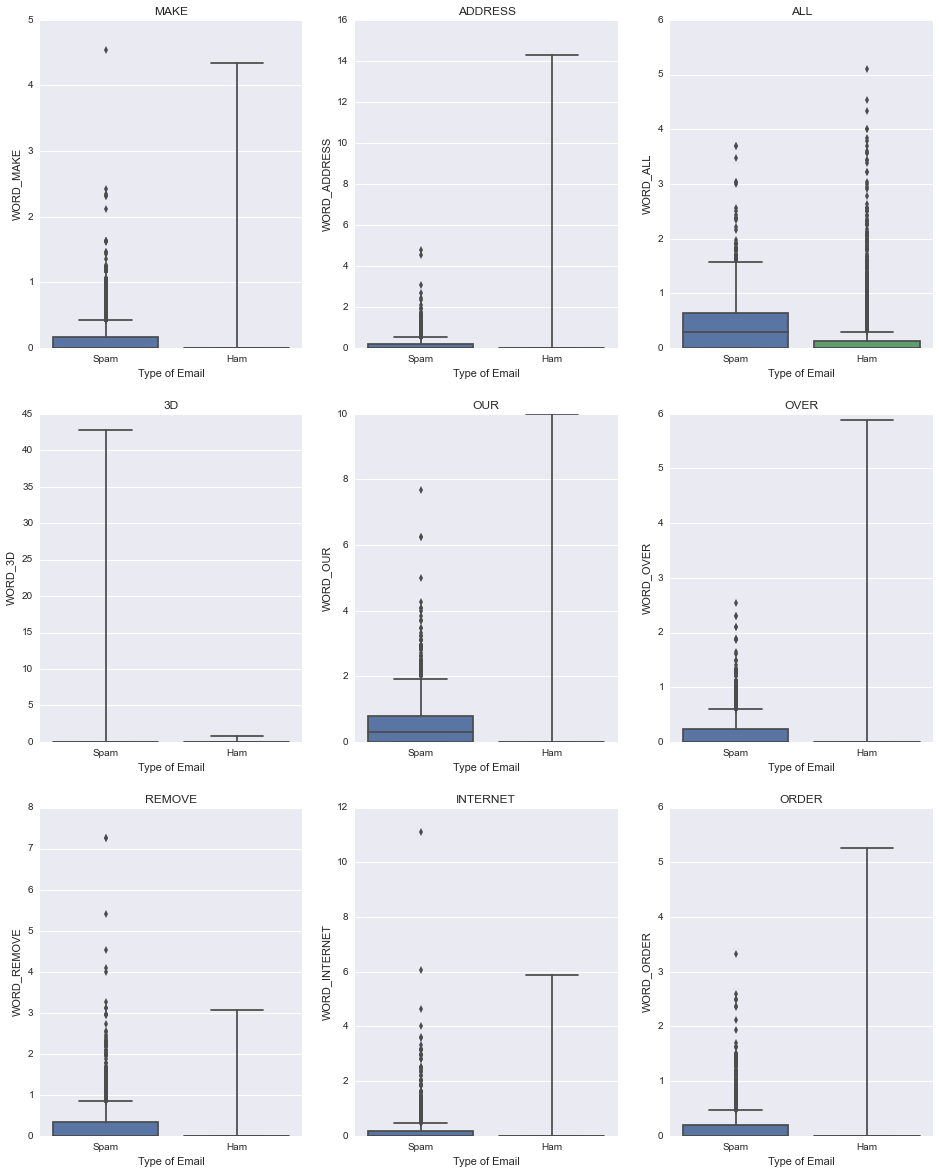

In [14]:
# Factor plots for the first 9 words
fig, subaxes = plt.subplots(3, 3, figsize=(16, 20))
for ii in range(0, 9):
    ax = sns.boxplot(x='TYPE', y=spam_df.columns[ii], data=spam_df, ax=subaxes[ii/3][ii%3])
    ax.set_xlabel('Type of Email')
    ax.set_xticklabels(['Spam', 'Ham'])
    ax.set_title(spam_df.columns[ii].split('_')[1])

Examining the distributions of the first nine words: make, address, all, 3d, our, over, remove, internet, and order based on classification shows a couple interesting things. The words make, our, over, remove, internet, and order appear more prevalent in spam emails than ham emails. The words address, all, and 3d are harder to decipher trends.

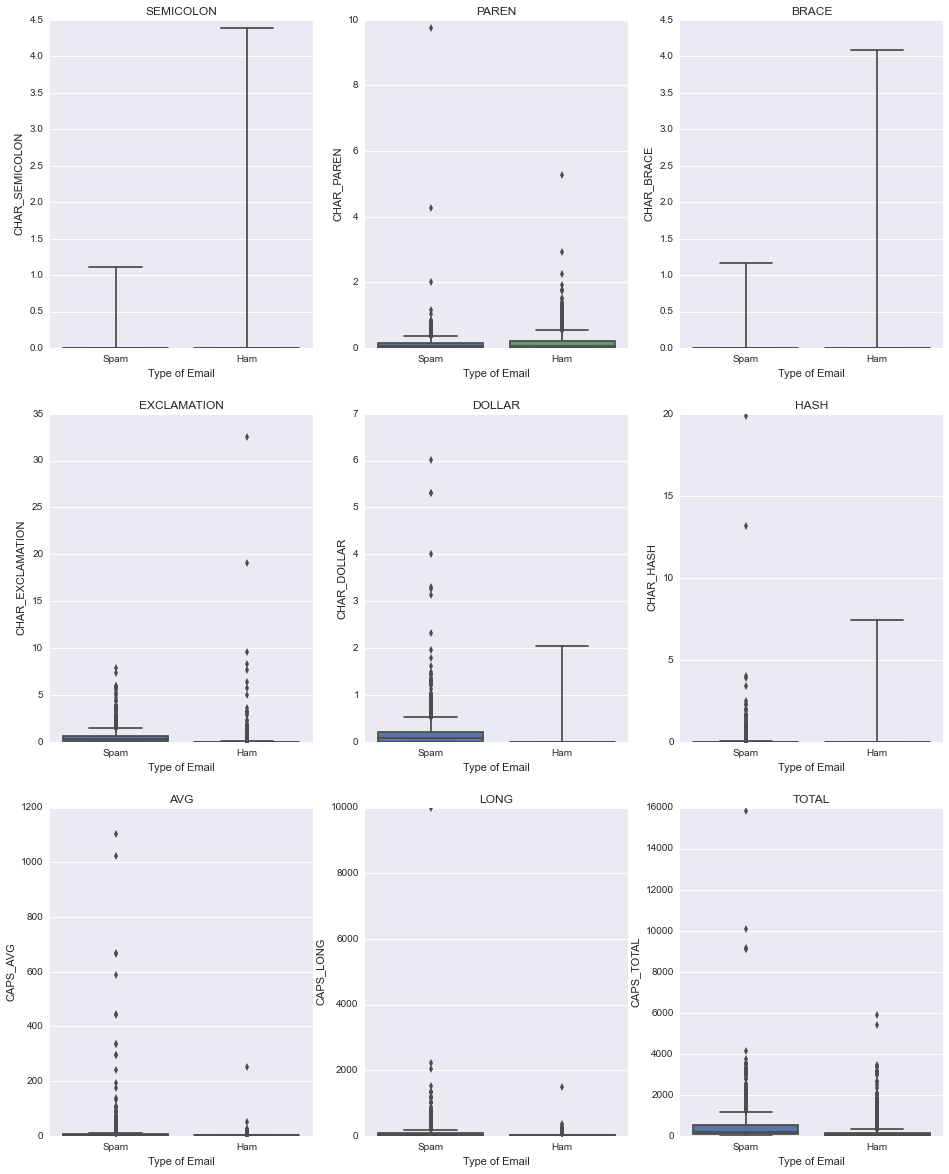

In [15]:
# Factor plots for characters and CAPS
fig, subaxes = plt.subplots(3, 3, figsize=(16, 20))
for ii in range(48, 57):
    ax = sns.boxplot(x='TYPE', y=spam_df.columns[ii], data=spam_df, ax=subaxes[(ii-48)/3][(ii-48)%3])
    ax.set_xlabel('Type of Email')
    ax.set_xticklabels(['Spam', 'Ham'])
    ax.set_title(spam_df.columns[ii].split('_')[1])

Examining the distributions of the special characters and sequences of capitals, the usage of parentheses, braces, exclamations and semicolons is similar in both spam and ham. In contrast, greater usage of dollar signs and hash tags and capital letters liekly indicates spam.

### Log Transform of Spam Data Variables

In order to make the data more symmetric and easier to visualize a log transform of the predictor variables is applied. An very small offset of one one-hundredth is added to any 0 count variables to avoid taking the log of zero.

In [16]:
# Log transform the first 57 variables
lspam_df = spam_df.drop('TYPE', axis=1).apply(lambda x: np.log(x + .01))

# Add back in 'TYPE' response variable to the transformed frame
lspam_df.loc[:, 'TYPE'] = spam_df.TYPE

lspam_df.describe()

WORD_MAKE  WORD_ADDRESS  WORD_ALL  WORD_3D  WORD_OUR  WORD_OVER  \
count       4601          4601      4601     4601      4601       4601   
mean    -3.82189      -3.87737  -2.98761 -4.55716   -3.0778   -3.85857   
std      1.50597       1.56487   2.00503 0.509703   2.03238     1.4782   
min     -4.60517      -4.60517  -4.60517 -4.60517  -4.60517   -4.60517   
25%     -4.60517      -4.60517  -4.60517 -4.60517  -4.60517   -4.60517   
50%     -4.60517      -4.60517  -4.60517 -4.60517  -4.60517   -4.60517   
75%     -4.60517      -4.60517  -0.84397 -4.60517 -0.941609   -4.60517   
max      1.51513       2.65956    1.6312  3.75701   2.30358    1.77326   

       WORD_REMOVE  WORD_INTERNET  WORD_ORDER  WORD_MAIL   ...     \
count         4601           4601        4601       4601   ...      
mean       -3.9539        -3.9628    -3.99243   -3.46424   ...      
std         1.4766           1.44     1.41281    1.88476   ...      
min       -4.60517       -4.60517    -4.60517   -4.60517   ...      
25%       -4.60517       -4.60517    -4.60517   -4.60517   ...      
50%       -4.60517       -4.60517    -4.60517   -4.60517   ...      
75%       -4.60517       -4.60517    -4.60517   -1.77196   ...      
max        1.98513        2.40875     1.66203    2.90087   ...      

       CHAR_SEMICOLON  CHAR_PAREN  CHAR_BRACE  CHAR_EXCLAMATION  CHAR_DOLLAR  \
count            4601        4601        4601              4601         4601   
mean         -4.20356    -2.92217    -4.34364          -2.93124     -3.76751   
std           0.99754     1.53236    0.783116           1.87164      1.37681   
min          -4.60517    -4.60517    -4.60517          -4.60517     -4.60517   
25%          -4.60517    -4.60517    -4.60517          -4.60517     -4.60517   
50%          -4.60517    -2.59027    -4.60517          -4.60517     -4.60517   
75%          -4.60517    -1.61949    -4.60517          -1.12393     -2.78062   
max           1.48047      2.2785     1.40879           3.48087      1.79392   

       CHAR_HASH   CAPS_AVG  CAPS_LONG  CAPS_TOTAL     TYPE  
count       4601       4601       4601        4601     4601  
mean    -4.22055   0.957978    2.76659      4.5331 0.394045  
std     0.987996   0.747958    1.45707     1.55669 0.488698  
min     -4.60517 0.00995033 0.00995033  0.00995033        0  
25%     -4.60517   0.468753    1.79342     3.55563        0  
50%     -4.60517   0.826804    2.70872     4.55398        0  
75%     -4.60517    1.31265    3.76143     5.58353        1  
max      2.98765    7.00534    9.20924     9.67036        1  

[8 rows x 58 columns]

### Scatterplot Matrices for Log Transform Spam Data

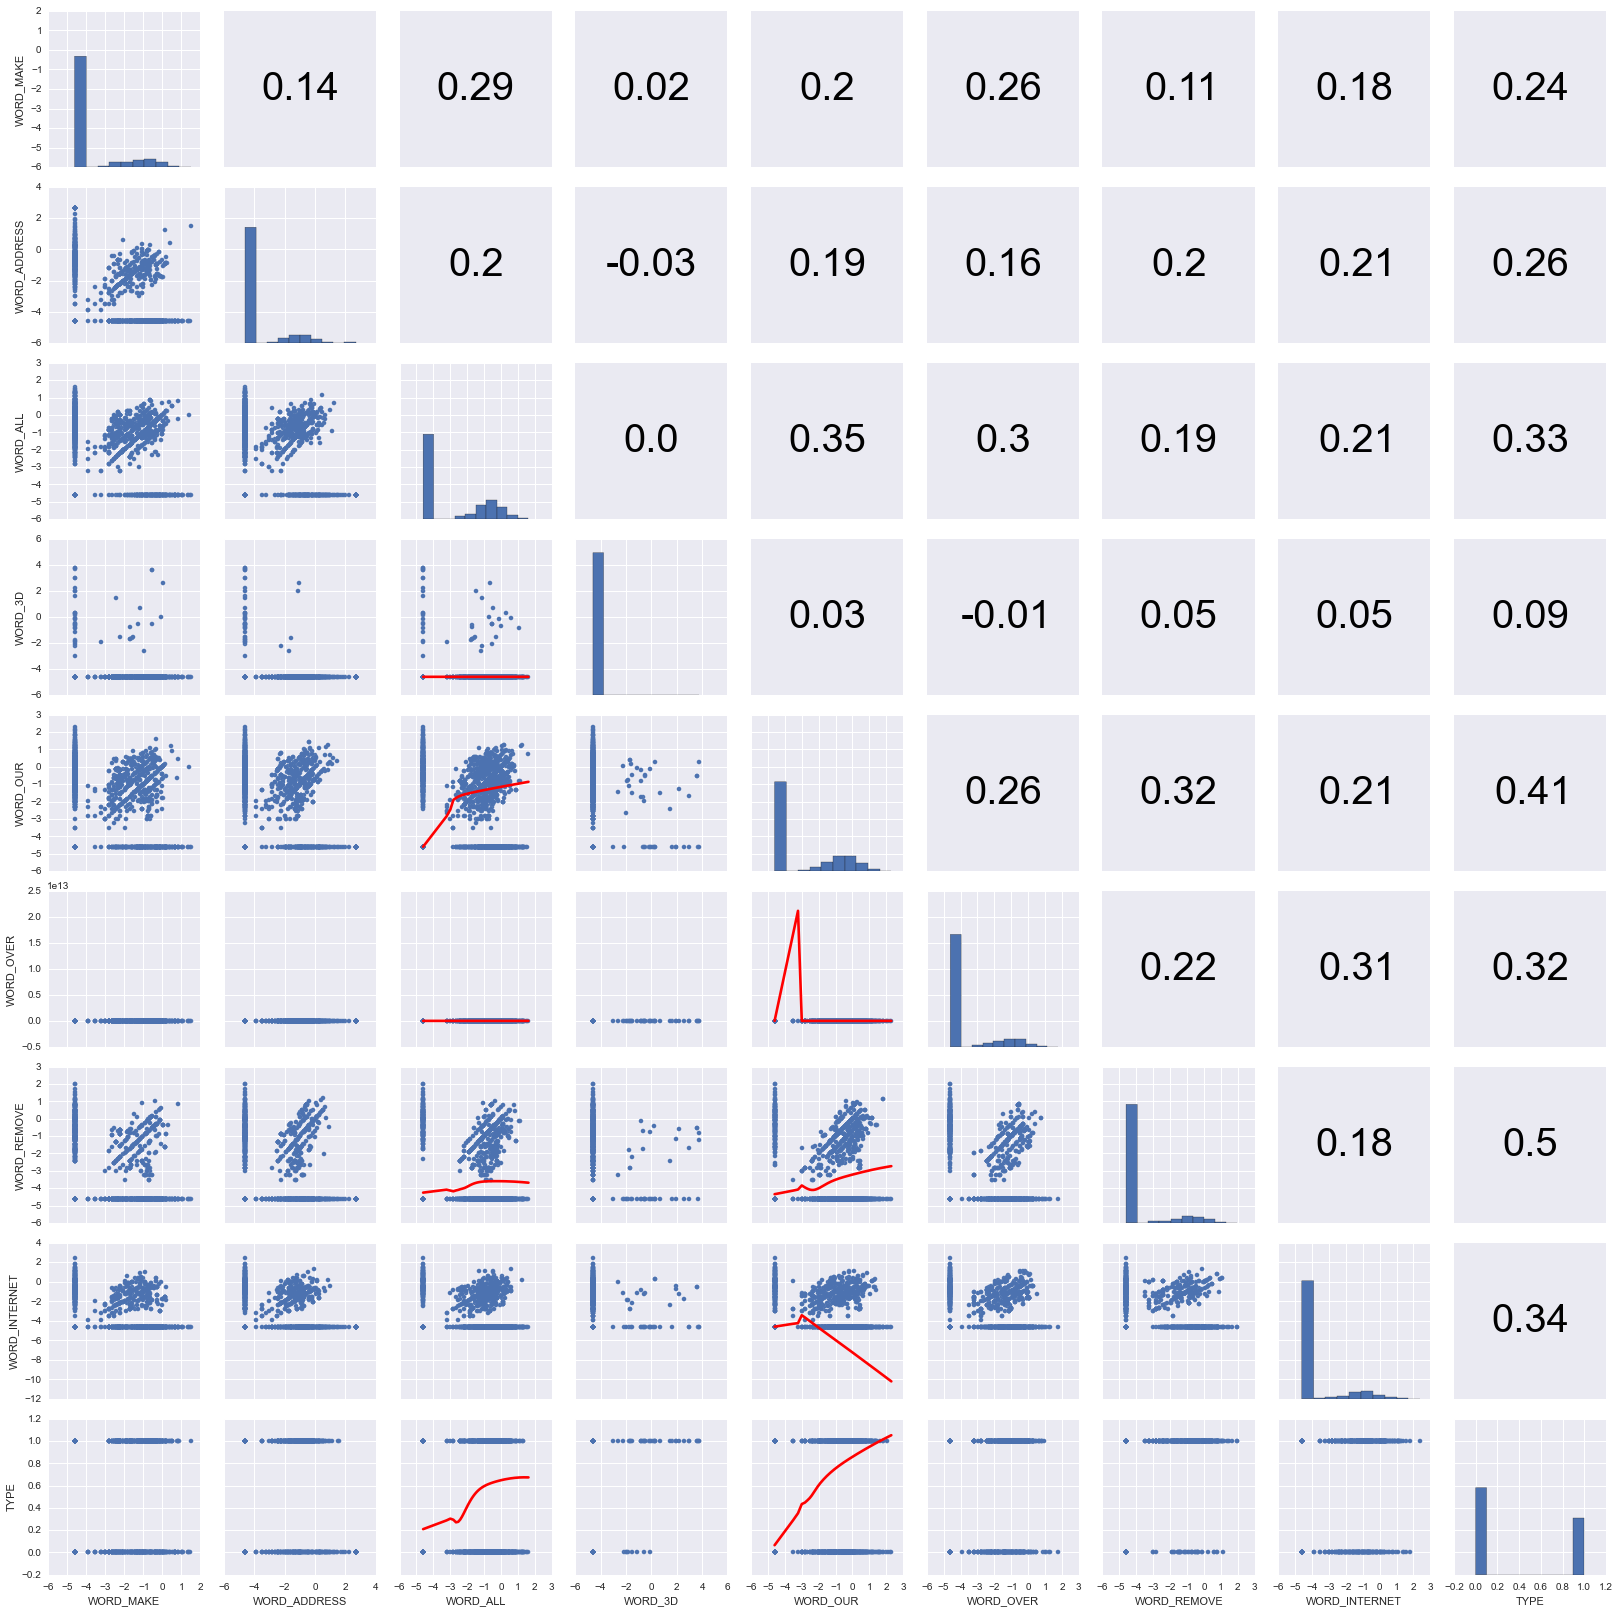

In [17]:
g = sns.pairplot(lspam_df.drop(lspam_df.columns[8:57], axis=1))
g.map_lower(sns.regplot, lowess=True, ci=None, line_kws={'color':'red'})
g.map_upper(pearsonr_plot)

# Suggest right clicking on image and opening in new tab

Looking at the pair wise relationships between the first eight words and email type, only two of the eight show strong positive relationships. Namely, the word our and email type (pearson-r of 0.41) and the word remove and email type (pearson-r of 0.5)

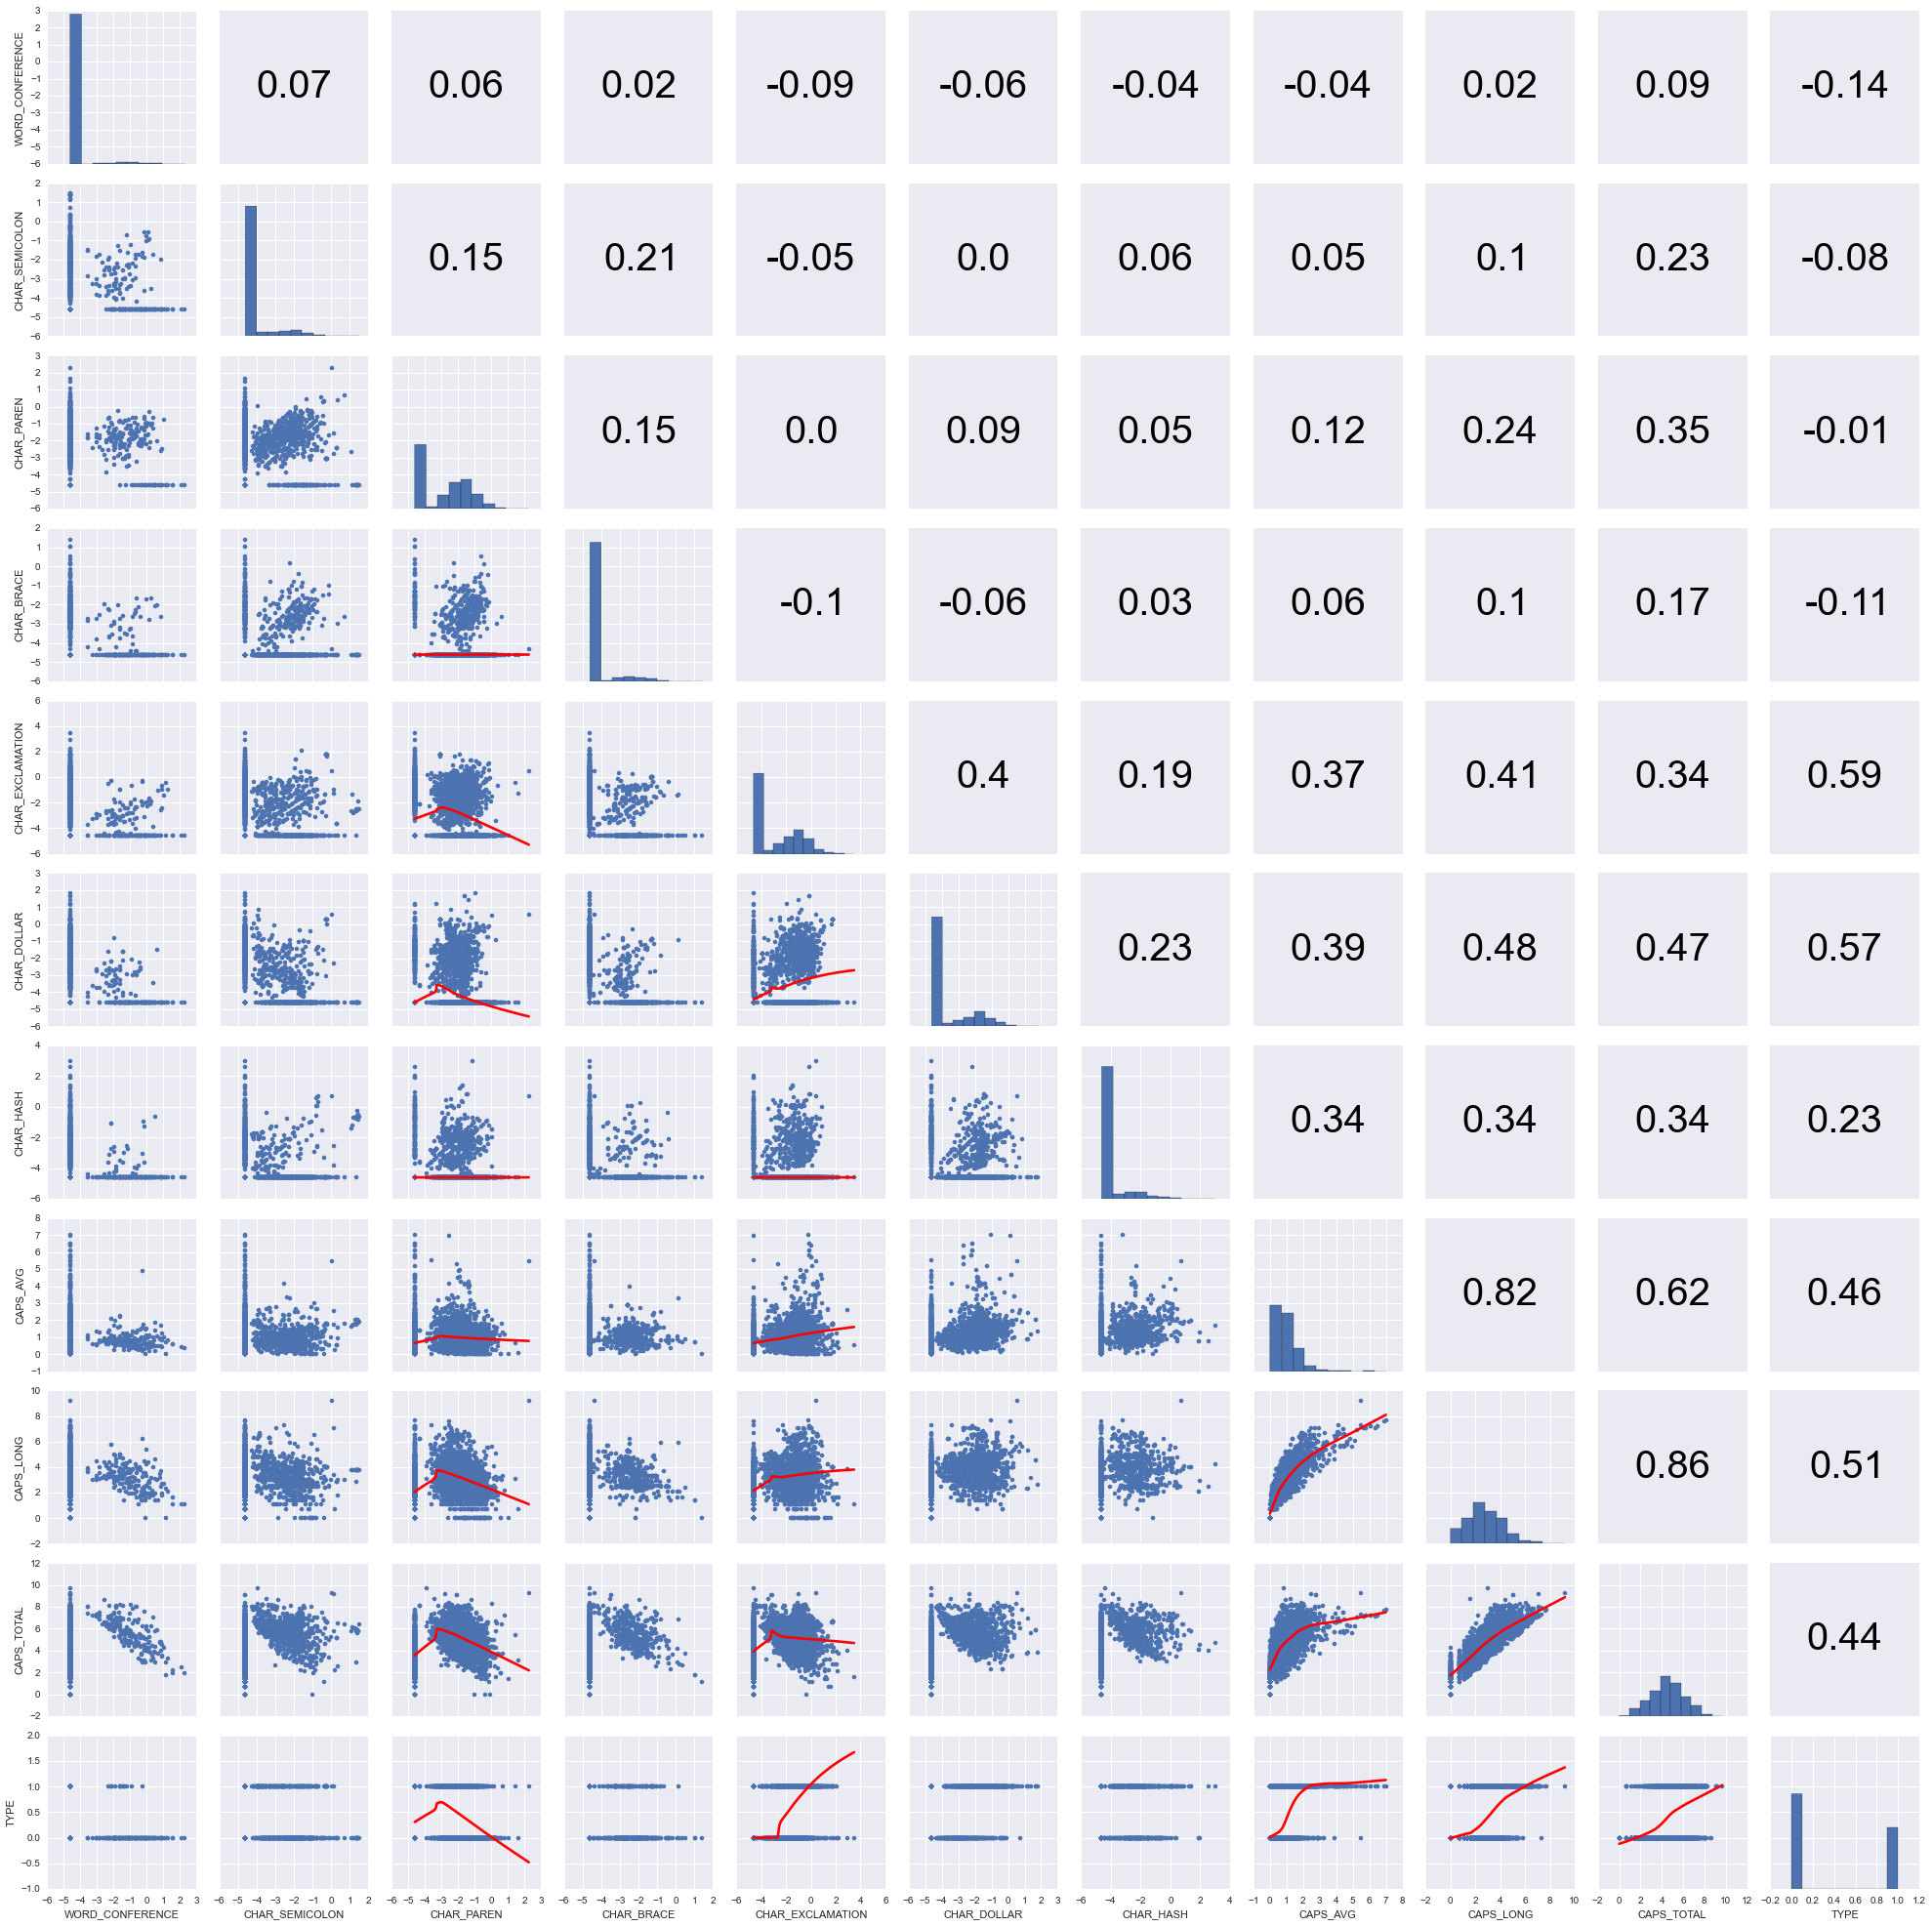

In [18]:
g = sns.pairplot(lspam_df.drop(lspam_df.columns[:47], axis=1))
g.map_lower(sns.regplot, lowess=True, ci=None, line_kws={'color':'red'})
g.map_upper(pearsonr_plot)

# Suggest right clicking on image and opening in new tab

Looking at the pair wise relationships between the special characters, capital letter sequences and email type, a few stand out. Strong positive relationships between exclamations, dollar signs, average length of captials, longest capitals sequence, and total captials with email type exist. This confirms the suspicious from above when analyzing the box plots. There are also strong positive correlations between dollar signs and longest sequential capitals, and exclamations and longest sequential capitals.

### Factor Plots for Log Transform Spam Data

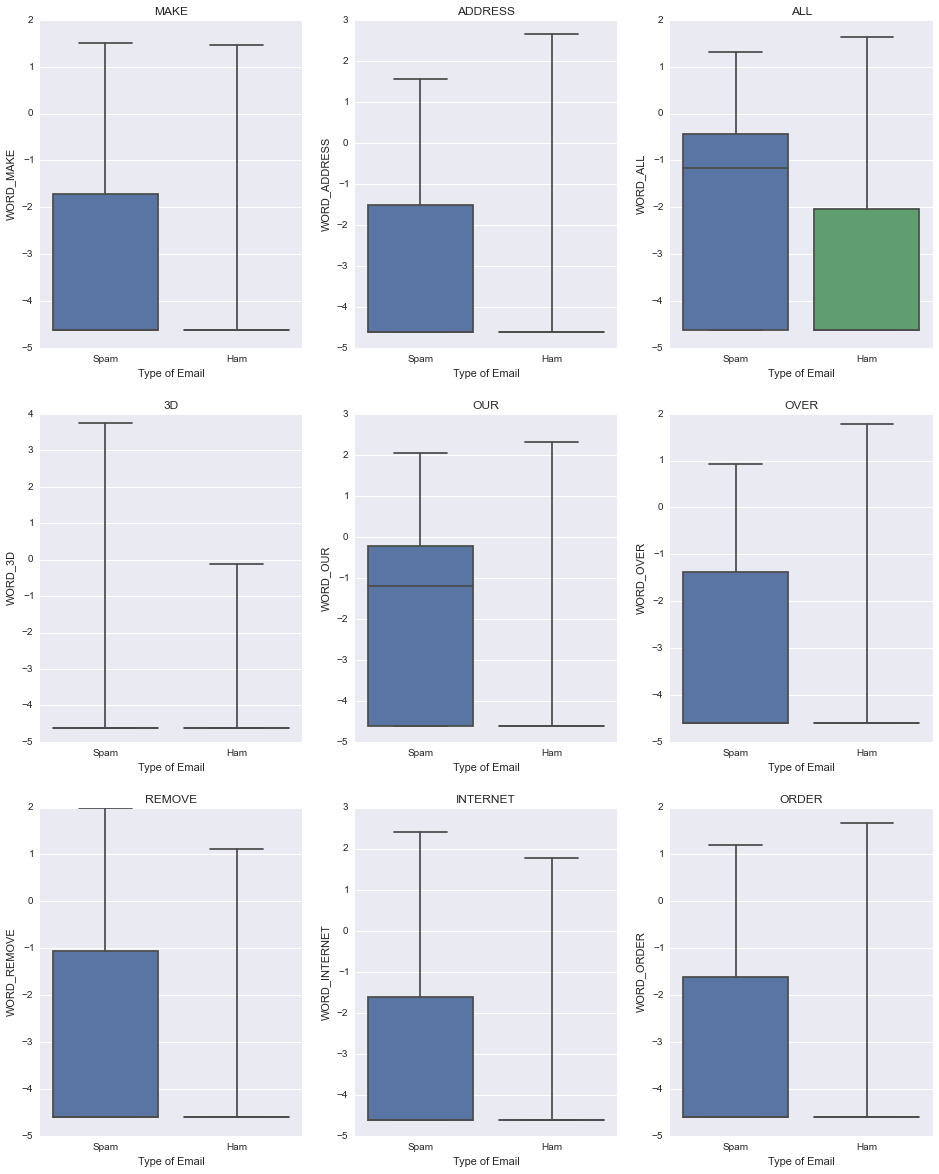

In [19]:
# Factor plots for the first 9 words
fig, subaxes = plt.subplots(3, 3, figsize=(16, 20))
for ii in range(0, 9):
    ax = sns.boxplot(x='TYPE', y=lspam_df.columns[ii], data=lspam_df, ax=subaxes[ii/3][ii%3])
    ax.set_xlabel('Type of Email')
    ax.set_xticklabels(['Spam', 'Ham'])
    ax.set_title(lspam_df.columns[ii].split('_')[1])

The log transformed data gives a bit more granularity into the first nine words. The appearance of any of the words expect all or 3d, are more likely to indicate spam than ham.

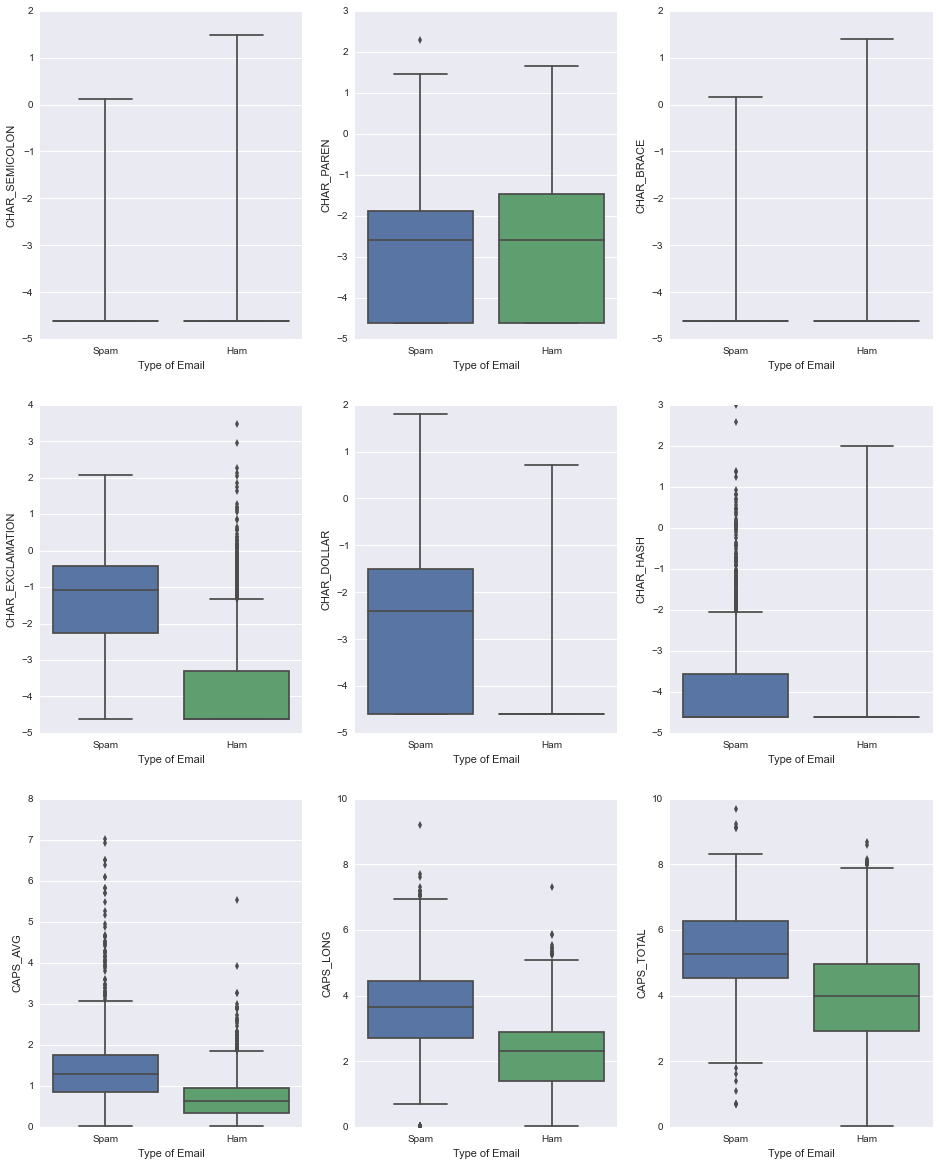

In [20]:
# Factor plots for characters and CAPS
fig, subaxes = plt.subplots(3, 3, figsize=(16, 20))
for ii in range(48, 57):
    ax = sns.boxplot(x='TYPE', y=lspam_df.columns[ii], data=lspam_df, ax=subaxes[(ii-48)/3][(ii-48)%3])
    ax.set_xlabel('Type of Email')
    ax.set_xticklabels(['Spam', 'Ham'])

The log transformed characters and capitalization further validates more exclamations, dollar signs, or capital letters is more liekly to be spam. The hash character is mroe prevalent in spam emails than ham emails.

### Principal Component Analysis for Spam Data

To assist in understanding the major predictor variables in combintion with the email classification prinicipal component analysis is done.

In [21]:
# Scale data
spam_df_vars = spam_df[spam_df.columns[:-1]]
spam_df_vars = (spam_df_vars - spam_df_vars.mean()) / spam_df_vars.std()

# PCA Singular value decomposition
spam_pca = sm_pca.pcasvd(spam_df_vars, keepdim=0, demean=False)

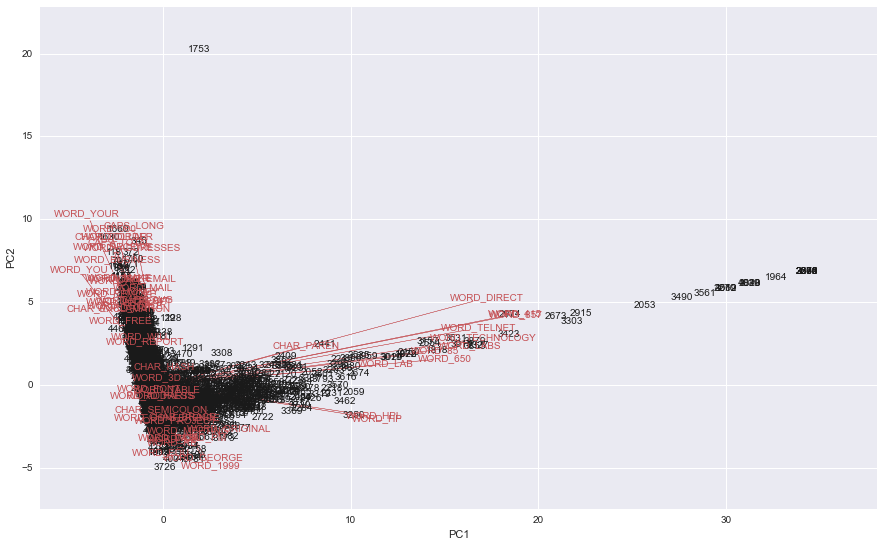

In [22]:
# Plot the principal components
plt.figure(1, figsize=(15,9))
biplot(plt, spam_pca, labels=spam_df_vars.index, xpc=1, ypc=2, arrow_scale=20)
plt.show()

The biplot of the first two principal components shows a few groups of words vary together. Most significantly, the words direct, technology, telnet, labs, 650, 415, 857 are largest in the first principal component. Perhaps the numbers represent area codes or parts of a phone number and the words seem to be all work related. Next, the words HP and HPL vary together which could be abbreviations for Hewlett Packard and Hewlett Packard Labs. The words your, business, and addresses and longest string of capitals all vary together strongly in the second principal component. Lastly, the words george and 1999 appear the opposite direction in the second prinicpal component. Most of the data entries are clustered close together except for 1753 which has a very large value in the second principal component.

In [23]:
# What is the outlier?
print 'Max projection =', spam_pca[0].max().max()
spam_pca_max_proj = np.where(spam_pca[0] == spam_pca[0].max().max())[0][0]
print 'Index =', spam_pca_max_proj

print spam_df.ix[spam_pca_max_proj]

Max projection = 50.9865074827
Index = 1753
WORD_MAKE                0
WORD_ADDRESS             0
WORD_ALL                 0
WORD_3D               0.04
WORD_OUR                 0
WORD_OVER                0
WORD_REMOVE              0
WORD_INTERNET            0
WORD_ORDER               0
WORD_MAIL                0
WORD_RECEIVE             0
WORD_WILL                0
WORD_PEOPLE              0
WORD_REPORT              0
WORD_ADDRESSES           0
WORD_FREE             0.02
WORD_BUSINESS            0
WORD_EMAIL               0
WORD_YOU              0.02
WORD_CREDIT              0
WORD_YOUR                0
WORD_FONT                0
WORD_000                 0
WORD_MONEY               0
WORD_HP                  0
WORD_HPL                 0
WORD_GEORGE              0
WORD_650                 0
WORD_LAB                 0
WORD_LABS                0
WORD_TELNET              0
WORD_857                 0
WORD_DATA                0
WORD_415                 0
WORD_85                  0
WORD_TECHNO

The outlier contains an outstanding 10,062 capital letters which is causing the strong pull in pricipal component two.

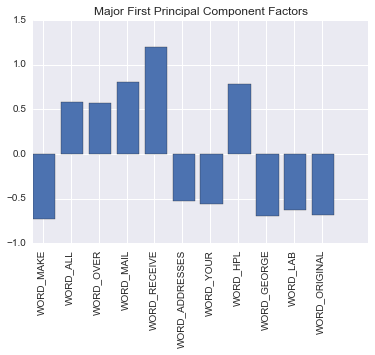

In [24]:
# Major Factors/Loadings of the first principal component
major_factors = []
major_factors_vals = []
cnt = 0
for ii in spam_pca[1][0]:
    if np.abs(ii) > 0.5:
        major_factors.append(cnt)
        major_factors_vals.append(ii)
    cnt = cnt+1

ind = np.arange(len(major_factors))
width = 0.35

plt.bar(ind, major_factors_vals)
plt.xticks(ind+width, spam_df.columns[major_factors], rotation='vertical')
plt.title('Major First Principal Component Factors')
plt.show()

The words receive, mail, hpl, george, lab, make, and original are significant factors in the first principal component. These keywords may be key to identifying work and personal emails.

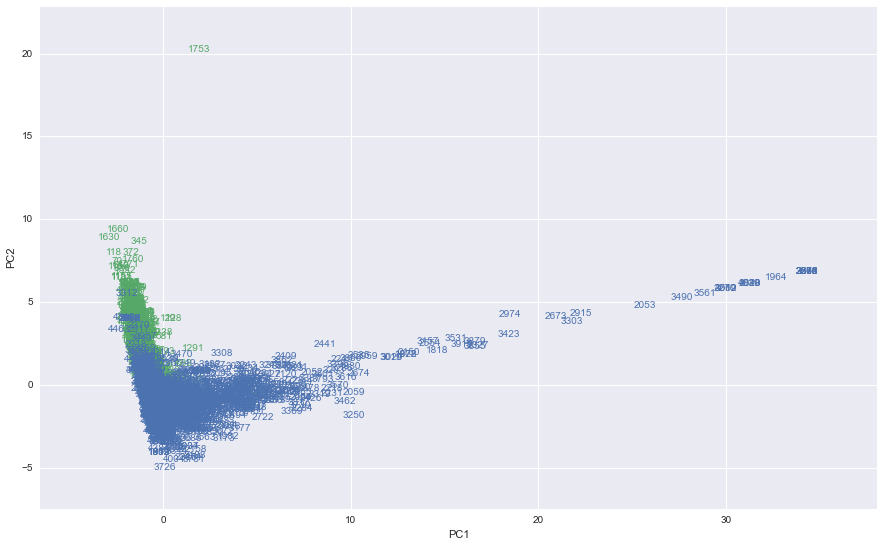

In [25]:
spam_colors = []
for ii in spam_df['TYPE']:
    if ii == 0: # Ham is blue
        spam_colors.append('b')
    else: # Spam is green
        spam_colors.append('g')

plt.figure(1, figsize=(15,9))
biplot(plt, spam_pca, labels=spam_df_vars.index, colors=spam_colors,
       xpc=1, ypc=2, show_arrows=False, arrow_scale=20)
plt.show()

Splitting the biplot by email classification type reveals a couple trends. Spam emails tend to be strongly positive in principal component two and slightly negative in principal component one. On the other hand, ham emails are very strongly positive in prinicpal component one or weakly negatively in principal component two. Perhaps this is the results of ham emails being strongly linked to either work or personal.

### Principal Component Analysis for Log Transformed Spam Data

In [26]:
# Scale data
lspam_df_vars = lspam_df[lspam_df.columns[:-1]]
lspam_df_vars = (lspam_df_vars - lspam_df_vars.mean()) / lspam_df_vars.std()

# PCA Singular value decomposition
lspam_pca = sm_pca.pcasvd(lspam_df_vars, keepdim=0, demean=False)

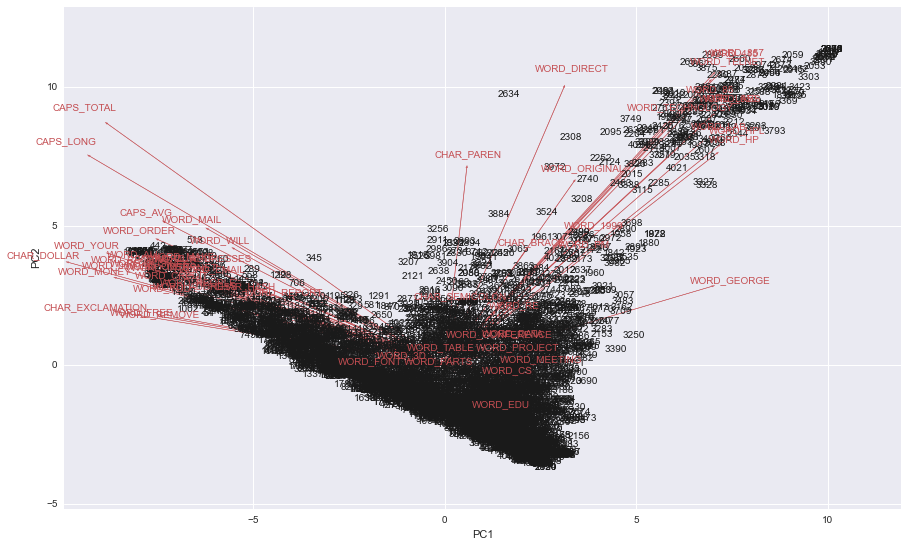

In [27]:
# Plot the principal components
plt.figure(1, figsize=(15,9))
biplot(plt, lspam_pca, labels=lspam_df_vars.index, xpc=1, ypc=2, arrow_scale=15)
plt.show()

The biplot of the log transformed data is more interesting. The words HP, HPL are more strongly grouped with 857, 415, telner, etc. than before making the work connection clearer. the word george is not strongly related to anything, as it is probably used in both work and personal emails. A group of exclamations, dollar sign, and capital letters is also visible. The 1753 outlier from before is not readily apparent.

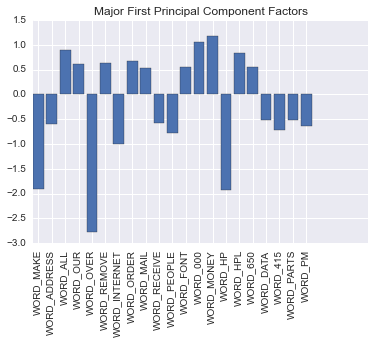

In [28]:
# Major Factors/Loadings of the first principal component
major_factors = []
major_factors_vals = []
cnt = 0
for ii in lspam_pca[1][0]:
    if np.abs(ii) > 0.5:
        major_factors.append(cnt)
        major_factors_vals.append(ii)
    cnt = cnt+1

ind = np.arange(len(major_factors))
width = 0.4

plt.bar(ind, major_factors_vals)
plt.xticks(ind+width, lspam_df.columns[major_factors], rotation='vertical')
plt.title('Major First Principal Component Factors')
plt.show()

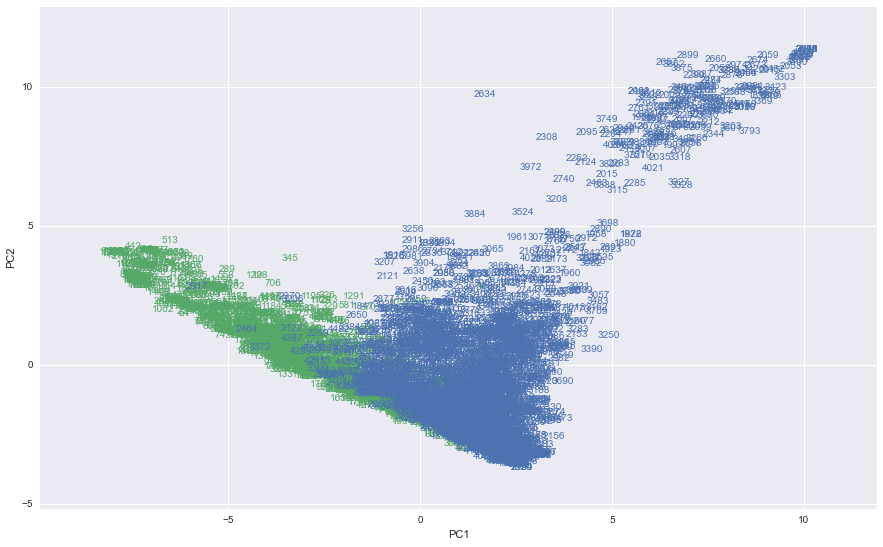

In [29]:
spam_colors = []
for ii in spam_df['TYPE']:
    if ii == 0: # Ham is blue
        spam_colors.append('b')
    else: # Spam is green
        spam_colors.append('g')

plt.figure(1, figsize=(15,9))
biplot(plt, lspam_pca, labels=lspam_df_vars.index, colors=spam_colors,
       xpc=1, ypc=2, show_arrows=False)
plt.show()

Spam emails are grouped negatively in the first principal component, whereas ham emails are positive in the first principal component.

## 2.2 Analysis

In order to build a spam classifier, logistic regression must be used since the response variable is binary. A model can be created using a generalized linear model with binomial response and the logit function as the link function. This allows the right hand side, the predictor variables and regression coefficients, to map to a value between zero and one. The regression coefficients β can be interpreted asimilarly to linear models, however the left hand side is a logit rather than a mean. "Thus, βj represents the change in the logit of the probability associated with a unit change in the j-th predictor holding all other predictors constant" [10]. 

### Spam Main Effects Model

In [30]:
# Main effects model
spam_glm = sm_glm('TYPE ~ ' + convert_df_to_patsy_rhs_formula(spam_df.drop('TYPE', axis=1)), 
                  data=spam_df, family=sm.families.Binomial()).fit()

spam_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   TYPE   No. Observations:                 4601
Model:                            GLM   Df Residuals:                     4543
Model Family:                Binomial   Df Model:                           57
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Wed, 21 Oct 2015   Deviance:                       1815.8
Time:                        19:20:54   Pearson chi2:                 1.81e+06
No. Iterations:                    16                                         
====================================================================================
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept           -1.5686      0.142    -11.044      0.000        -1.847    -1.290
WORD_MAKE           -0.3895      0.231     -1.683      0.092        -0.843     0.064
WORD_ADDRESS        -0.1458      0.069     -2.104      0.035        -0.282    -0.010
WORD_ALL             0.1141      0.110      1.035      0.301        -0.102     0.330
WORD_3D              2.2515      1.507      1.494      0.135        -0.702     5.205
WORD_OUR             0.5624      0.102      5.524      0.000         0.363     0.762
WORD_OVER            0.8830      0.250      3.534      0.000         0.393     1.373
WORD_REMOVE          2.2785      0.333      6.846      0.000         1.626     2.931
WORD_INTERNET        0.5696      0.168      3.387      0.001         0.240     0.899
WORD_ORDER           0.7343      0.285      2.577      0.010         0.176     1.293
WORD_MAIL            0.1275      0.073      1.755      0.079        -0.015     0.270
WORD_RECEIVE        -0.2557      0.298     -0.858      0.391        -0.840     0.328
WORD_WILL           -0.1383      0.074     -1.868      0.062        -0.283     0.007
WORD_PEOPLE         -0.0796      0.230     -0.346      0.730        -0.531     0.372
WORD_REPORT          0.1447      0.136      1.061      0.289        -0.123     0.412
WORD_ADDRESSES       1.2362      0.725      1.704      0.088        -0.186     2.658
WORD_FREE            1.0386      0.146      7.128      0.000         0.753     1.324
WORD_BUSINESS        0.9599      0.225      4.264      0.000         0.519     1.401
WORD_EMAIL           0.1203      0.117      1.027      0.305        -0.109     0.350
WORD_YOU             0.0813      0.035      2.320      0.020         0.013     0.150
WORD_CREDIT          1.0474      0.538      1.946      0.052        -0.008     2.102
WORD_YOUR            0.2419      0.052      4.615      0.000         0.139     0.345
WORD_FONT            0.2013      0.163      1.238      0.216        -0.117     0.520
WORD_000             2.2452      0.471      4.762      0.000         1.321     3.169
WORD_MONEY           0.4264      0.162      2.630      0.009         0.109     0.744
WORD_HP             -1.9204      0.313     -6.139      0.000        -2.534    -1.307
WORD_HPL            -1.0402      0.440     -2.366      0.018        -1.902    -0.179
WORD_GEORGE        -11.7672      2.113     -5.569      0.000       -15.909    -7.626
WORD_650             0.4454      0.199      2.237      0.025         0.055     0.836
WORD_LAB            -2.4864      1.502     -1.656      0.098        -5.429     0.457
WORD_LABS           -0.3299      0.314     -1.052      0.293        -0.945     0.285
WORD_TELNET         -0.1702      0.482     -0.353      0.724        -1.114     0.774
WORD_857             2.5488      3.283      0.776      0.438        -3.886     8.984
WORD_DATA           -0.7383      0.312     -2.369      0.018        -1.349    -0.127
WORD_415         

In [31]:
# Model Utility test
spam_null = sm_glm('TYPE~1', data=spam_df, family=sm.families.Binomial()).fit()

In [32]:
# ANOVA chi-square not implemented in statsmodels, made custom above
# https://github.com/statsmodels/statsmodels/issues/825
# http://stackoverflow.com/questions/27328623/anova-test-for-glm-in-python

anova_glm(spam_null, spam_glm)

df_resid  deviance  df_diff  deviance_diff  Pr(>Chisq)
0      4600   6170.15        0            nan         nan
1      4543   1815.77       57        4354.39           0

A simple main effects models using all the predictor variables shows significance over the null model at the 0.01 level. The main effects model has a deviance of 1815.8 on 4,543 degress of freedom. A number of terms in to model are also signifcant at the 0.01 level including the intercept, the words our, over, remove, internet, free, business, your, money, hp, 85, technology, meeting, project, re, and edu, the characters semicolon, exclamation, and dollar sign, as well as the longest sequence of capitals and the total number of capitals.

### LSpam Main Effects Model

In [33]:
# Main effects model
lspam_glm = sm_glm('TYPE ~ ' + convert_df_to_patsy_rhs_formula(lspam_df.drop('TYPE', axis=1)), 
                  data=lspam_df, family=sm.families.Binomial()).fit()

lspam_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   TYPE   No. Observations:                 4601
Model:                            GLM   Df Residuals:                     4543
Model Family:                Binomial   Df Model:                           57
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -681.39
Date:                Wed, 21 Oct 2015   Deviance:                       1362.8
Time:                        19:20:58   Pearson chi2:                 2.14e+04
No. Iterations:                    14                                         
====================================================================================
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept          -26.4545      9.825     -2.693      0.007       -45.711    -7.198
WORD_MAKE           -0.1347      0.059     -2.282      0.022        -0.250    -0.019
WORD_ADDRESS        -0.0419      0.052     -0.810      0.418        -0.143     0.059
WORD_ALL            -0.1101      0.042     -2.605      0.009        -0.193    -0.027
WORD_3D              0.1542      0.180      0.857      0.391        -0.198     0.507
WORD_OUR             0.2653      0.040      6.568      0.000         0.186     0.344
WORD_OVER            0.0769      0.060      1.280      0.201        -0.041     0.195
WORD_REMOVE          0.5190      0.066      7.868      0.000         0.390     0.648
WORD_INTERNET        0.1947      0.061      3.212      0.001         0.076     0.313
WORD_ORDER           0.0239      0.072      0.333      0.739        -0.117     0.165
WORD_MAIL            0.0407      0.044      0.915      0.360        -0.046     0.128
WORD_RECEIVE        -0.0954      0.069     -1.379      0.168        -0.231     0.040
WORD_WILL           -0.0944      0.035     -2.663      0.008        -0.164    -0.025
WORD_PEOPLE         -0.2084      0.064     -3.264      0.001        -0.334    -0.083
WORD_REPORT          0.2098      0.077      2.731      0.006         0.059     0.360
WORD_ADDRESSES       0.2962      0.153      1.938      0.053        -0.003     0.596
WORD_FREE            0.2734      0.042      6.548      0.000         0.192     0.355
WORD_BUSINESS        0.2536      0.060      4.221      0.000         0.136     0.371
WORD_EMAIL          -0.1248      0.049     -2.545      0.011        -0.221    -0.029
WORD_YOU             0.0171      0.035      0.485      0.628        -0.052     0.086
WORD_CREDIT          0.1567      0.102      1.533      0.125        -0.044     0.357
WORD_YOUR            0.1134      0.037      3.042      0.002         0.040     0.186
WORD_FONT            0.0524      0.088      0.594      0.553        -0.121     0.225
WORD_000             0.2150      0.081      2.654      0.008         0.056     0.374
WORD_MONEY           0.3352      0.070      4.811      0.000         0.199     0.472
WORD_HP             -0.7604      0.084     -9.004      0.000        -0.926    -0.595
WORD_HPL            -0.0608      0.093     -0.656      0.512        -0.243     0.121
WORD_GEORGE         -1.3043      0.198     -6.590      0.000        -1.692    -0.916
WORD_650             0.3696      0.086      4.319      0.000         0.202     0.537
WORD_LAB            -0.2015      0.148     -1.358      0.174        -0.492     0.089
WORD_LABS            0.0081      0.106      0.076      0.940        -0.201     0.217
WORD_TELNET         -0.1527      0.269     -0.568      0.570        -0.680     0.374
WORD_857            -0.3447      0.390     -0.883      0.377        -1.109     0.420
WORD_DATA           -0.1646      0.084     -1.968      0.049        -0.329    -0.001
WORD_415         

In [34]:
anova_glm(spam_null, lspam_glm)

df_resid  deviance  df_diff  deviance_diff  Pr(>Chisq)
0      4600   6170.15        0            nan         nan
1      4543   1362.78       57        4807.37           0

The main effects model of the log transformed data has a deviance of 1362.8 which is much lower than the original main effects model above. This indicates the log transformed main effects model is probably a better fit. In this model, the intercept, the words all, out, remove, internet, will, people, report, free, business, your, 000, money, hp, george, 85, 1999, meeting, project, re, edu, and conference, the characters exclamation, and dollar sign, and the average amount of capitals sequence and the total amount of capitals were all terms deemed significant. The majority of these terms intersect with the ones found earlier in the untransformed model. One notable exception is that george is significant in the log transformed model but not the untransformed model.

In [35]:
# Main effects model - only words
lspam_glm_words = sm_glm('TYPE ~ ' + convert_df_to_patsy_rhs_formula(lspam_df.drop(lspam_df.columns[48:], axis=1)), 
                  data=lspam_df, family=sm.families.Binomial()).fit()

lspam_glm_words.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   TYPE   No. Observations:                 4601
Model:                            GLM   Df Residuals:                     4552
Model Family:                Binomial   Df Model:                           48
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -879.51
Date:                Wed, 21 Oct 2015   Deviance:                       1759.0
Time:                        19:21:00   Pearson chi2:                 1.44e+04
No. Iterations:                    14                                         
===================================================================================
                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept         -15.0439     10.343     -1.455      0.146       -35.316     5.228
WORD_MAKE          -0.0576      0.050     -1.151      0.250        -0.156     0.040
WORD_ADDRESS       -0.0358      0.041     -0.878      0.380        -0.116     0.044
WORD_ALL           -0.0269      0.035     -0.757      0.449        -0.096     0.043
WORD_3D             0.3443      0.181      1.907      0.057        -0.010     0.698
WORD_OUR            0.2600      0.035      7.448      0.000         0.192     0.328
WORD_OVER           0.1493      0.050      2.987      0.003         0.051     0.247
WORD_REMOVE         0.5825      0.062      9.463      0.000         0.462     0.703
WORD_INTERNET       0.2486      0.053      4.710      0.000         0.145     0.352
WORD_ORDER          0.2522      0.060      4.225      0.000         0.135     0.369
WORD_MAIL           0.0980      0.038      2.558      0.011         0.023     0.173
WORD_RECEIVE       -0.1037      0.066     -1.570      0.116        -0.233     0.026
WORD_WILL          -0.0680      0.031     -2.158      0.031        -0.130    -0.006
WORD_PEOPLE        -0.1084      0.054     -2.015      0.044        -0.214    -0.003
WORD_REPORT         0.2142      0.065      3.320      0.001         0.088     0.341
WORD_ADDRESSES      0.1819      0.131      1.391      0.164        -0.074     0.438
WORD_FREE           0.4068      0.037     10.992      0.000         0.334     0.479
WORD_BUSINESS       0.2418      0.055      4.398      0.000         0.134     0.350
WORD_EMAIL         -0.0168      0.042     -0.395      0.693        -0.100     0.066
WORD_YOU            0.0157      0.029      0.536      0.592        -0.042     0.073
WORD_CREDIT         0.3782      0.086      4.374      0.000         0.209     0.548
WORD_YOUR           0.1655      0.031      5.323      0.000         0.105     0.226
WORD_FONT           0.1910      0.057      3.369      0.001         0.080     0.302
WORD_000            0.4665      0.067      7.001      0.000         0.336     0.597
WORD_MONEY          0.4686      0.064      7.352      0.000         0.344     0.593
WORD_HP            -0.6853      0.072     -9.461      0.000        -0.827    -0.543
WORD_HPL           -0.1475      0.087     -1.691      0.091        -0.318     0.023
WORD_GEORGE        -1.2233      0.170     -7.187      0.000        -1.557    -0.890
WORD_650            0.3428      0.080      4.296      0.000         0.186     0.499
WORD_LAB           -0.3322      0.136     -2.440      0.015        -0.599    -0.065
WORD_LABS          -0.0122      0.096     -0.127      0.899        -0.200     0.176
WORD_TELNET        -0.2530      0.243     -1.039      0.299        -0.730     0.224
WORD_857           -0.3187      0.339     -0.939      0.348        -0.984     0.347
WORD_DATA          -0.1498      0.077     -1.942      0.052        -0.301     0.001
WORD_415            0.5811      0.350      1.662      

In [36]:
anova_glm(lspam_glm_words, lspam_glm)

df_resid  deviance  df_diff  deviance_diff  Pr(>Chisq)
0      4552   1759.01        0            nan         nan
1      4543   1362.78        9        396.229           0

Creating a model simply based on words of the log transformed data has a similar deviance to the untransformed main effects model. When comparing against the log transformed main effects model the additional charater terms and capialization metrics are deemed significant by the chi-squared test. 

### Drop 1 tests

Not readily available in Python

### AIC and BIC Model Comparisons

Looking at AIC and BIC to compare models the log transformed main effects model comes as the best for both metrics. 

In [37]:
print spam_glm.aic
print lspam_glm.aic
print lspam_glm_words.aic

nan
1478.78178087
1857.01057271


In [38]:
print spam_glm.bic
print lspam_glm.bic
print lspam_glm_words.bic

-36500.0280431
-36953.0117397
-36632.6892084


### Parameter Interpretation

In [39]:
# How much does a one unit change in the number of CAPS affect the odds?
print 'spam_glm - CAPS_TOTAL coef', (np.exp( spam_glm.params['CAPS_TOTAL'])-1)*100

spam_glm - CAPS_TOTAL coef 0.0844019511954


As discussed earlier in order to understand the effects of a coefficient on the odds the coefficent must be raised to the exponential function. In the main effects model the each additional capital letter increases the odds the email is spam by 0.0844.

In [40]:
#  Is variable 57 significant in the model? 
#  use the likelihood ratio test
#spam.nc <- glm(V58~., data=spam[,-57], family = binomial)
#anova(spam.nc, spam.glm, test = "Chisq")

spam_glm_nocaps = sm_glm('TYPE ~ ' + convert_df_to_patsy_rhs_formula(spam_df.drop(['CAPS_TOTAL', 'TYPE'], axis=1)), 
                         data=spam_df, family=sm.families.Binomial()).fit()

spam_glm_nocaps.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   TYPE   No. Observations:                 4601
Model:                            GLM   Df Residuals:                     4544
Model Family:                Binomial   Df Model:                           56
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Wed, 21 Oct 2015   Deviance:                       1835.9
Time:                        19:21:15   Pearson chi2:                 3.24e+06
No. Iterations:                    16                                         
====================================================================================
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept           -1.4518      0.137    -10.579      0.000        -1.721    -1.183
WORD_MAKE           -0.3872      0.230     -1.682      0.093        -0.838     0.064
WORD_ADDRESS        -0.1533      0.069     -2.206      0.027        -0.289    -0.017
WORD_ALL             0.1105      0.110      1.007      0.314        -0.105     0.325
WORD_3D              2.3244      1.514      1.535      0.125        -0.643     5.292
WORD_OUR             0.5532      0.102      5.422      0.000         0.353     0.753
WORD_OVER            0.8659      0.250      3.467      0.001         0.376     1.355
WORD_REMOVE          2.2483      0.332      6.767      0.000         1.597     2.900
WORD_INTERNET        0.5651      0.167      3.386      0.001         0.238     0.892
WORD_ORDER           0.8230      0.287      2.866      0.004         0.260     1.386
WORD_MAIL            0.1235      0.072      1.725      0.084        -0.017     0.264
WORD_RECEIVE        -0.2458      0.297     -0.828      0.408        -0.828     0.336
WORD_WILL           -0.1513      0.074     -2.048      0.041        -0.296    -0.006
WORD_PEOPLE         -0.0814      0.228     -0.356      0.721        -0.529     0.366
WORD_REPORT          0.1313      0.136      0.967      0.334        -0.135     0.398
WORD_ADDRESSES       1.2938      0.729      1.774      0.076        -0.136     2.724
WORD_FREE            1.0270      0.145      7.070      0.000         0.742     1.312
WORD_BUSINESS        0.9853      0.229      4.311      0.000         0.537     1.433
WORD_EMAIL           0.0965      0.117      0.827      0.408        -0.132     0.325
WORD_YOU             0.0713      0.035      2.045      0.041         0.003     0.140
WORD_CREDIT          1.0899      0.544      2.004      0.045         0.024     2.156
WORD_YOUR            0.2360      0.052      4.521      0.000         0.134     0.338
WORD_FONT            0.2050      0.161      1.272      0.203        -0.111     0.521
WORD_000             2.3602      0.488      4.836      0.000         1.404     3.317
WORD_MONEY           0.4244      0.163      2.600      0.009         0.104     0.744
WORD_HP             -1.8529      0.303     -6.108      0.000        -2.448    -1.258
WORD_HPL            -0.9478      0.420     -2.258      0.024        -1.771    -0.125
WORD_GEORGE        -12.3757      2.152     -5.751      0.000       -16.594    -8.158
WORD_650             0.4031      0.190      2.121      0.034         0.031     0.776
WORD_LAB            -2.4162      1.435     -1.684      0.092        -5.228     0.395
WORD_LABS           -0.3897      0.318     -1.226      0.220        -1.013     0.233
WORD_TELNET         -0.2037      0.554     -0.368      0.713        -1.289     0.882
WORD_857             2.8164      3.269      0.862      0.389        -3.590     9.223
WORD_DATA           -0.5866      0.265     -2.210      0.027        -1.107    -0.066
WORD_415         

In [41]:
anova_glm(spam_glm_nocaps, spam_glm)

df_resid  deviance  df_diff  deviance_diff  Pr(>Chisq)
0      4544   1835.93        0            nan         nan
1      4543   1815.77        1        20.1621  7.1148e-06

The significance of total capitals in the model is determined by comparing the main effects model to a new main effects model with the total capitals term. By the chi-squared test the number of capitals in the email is significant at the 0.01 level. This isn't very surprising since each additional capital letter accounts for a 0.08 change in the odds of the email being spam. Thus, every 12.5 additional capitals increases the probability of spam by 10%!

# 3 Evidence

### Diagnostics

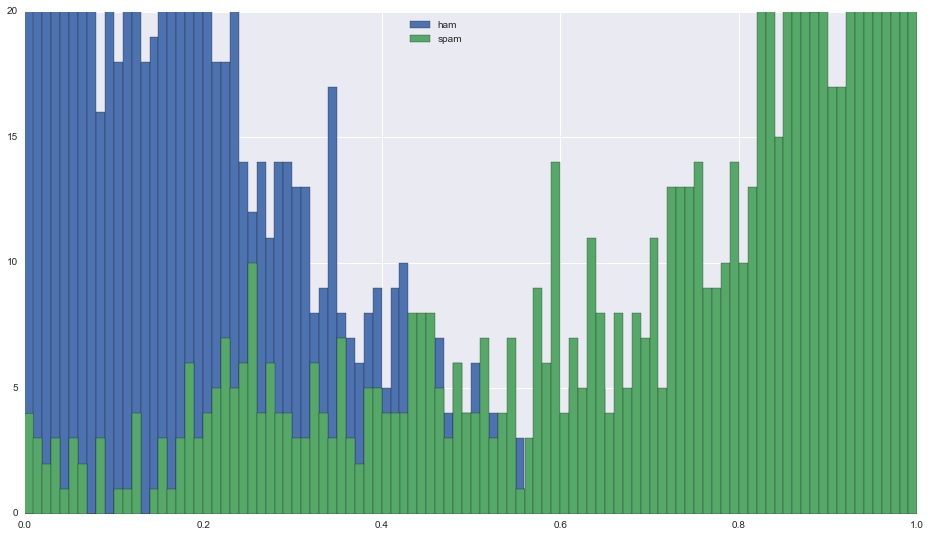

In [42]:
fitted_ham = np.array(spam_glm.fittedvalues[~spam_df['TYPE'].astype(bool)])
fitted_spam = np.array(spam_glm.fittedvalues[spam_df['TYPE'].astype(bool)])

plt.figure(figsize=(16, 9))
plt.hist(fitted_ham, bins=100, stacked=True, color='b', label="ham") # Ham is blue
plt.hist(fitted_spam, bins=100, stacked=True, color='g', label="spam") # Spam is green
plt.ylim([0, 20]) # Zoom in to try and identify suitable threshold
plt.legend(bbox_to_anchor=(0.5, 1))
plt.show()

The histogram of the main effects model fitted values shows overlapping distribution of ham and spam. A sizeable amout of spam emails were fitted to probabilities of being spam less than 0.4, with some even less than 0.1. Ham emails were better fitted, with only a couple given probabilities of being spam greater than 0.5 and none greater than 0.6.

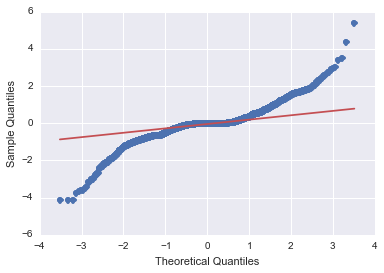

In [43]:
# Q-Q plot of the quantiles of x versus the quantiles/ppf of a distribution
fig = sm.qqplot(spam_glm.resid_deviance, line='q')
plt.show()

The QQ plot shows heavy tailed data, but that is unsurpising since the response is binary 0 or 1.

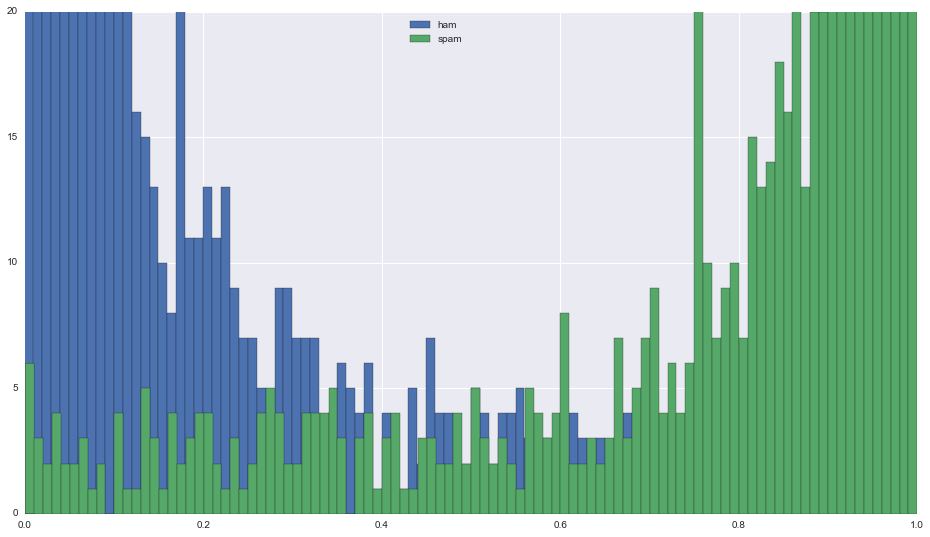

In [44]:
lfitted_ham = np.array(lspam_glm.fittedvalues[~spam_df['TYPE'].astype(bool)])
lfitted_spam = np.array(lspam_glm.fittedvalues[spam_df['TYPE'].astype(bool)])

plt.figure(figsize=(16, 9))
plt.hist(lfitted_ham, bins=100, stacked=True, color='b', label="ham") # Ham is blue
plt.hist(lfitted_spam, bins=100, stacked=True, color='g', label="spam") # Spam is green
plt.ylim([0, 20]) # Zoom in to try and identify suitable threshold
plt.legend(bbox_to_anchor=(0.5, 1))
plt.show()

The histogram of the log transformed main effects shows similar issues to the untransformed main effects. However, the distributions for both spam and ham seem to have smaller standard deviations and are more closely grouped around 1 and 0 respectively. The spam still shows up in fitted values down to 0.02. Some ham emails are given probabilities of being spam above 0.6. 

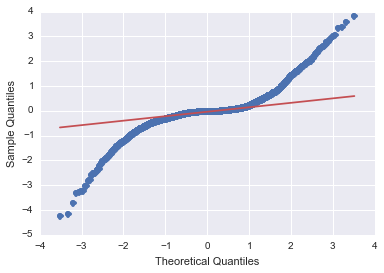

In [45]:
# Q-Q plot of the quantiles of x versus the quantiles/ppf of a distribution
fig = sm.qqplot(lspam_glm.resid_deviance, line='q')
plt.show()

The QQ plot for the log transformed main effects model is even more heavy tailed than the untransformed main effects as noted earlier by loooking at the histogram.

### Stepwise

A stepwise model using forward selection based on BIC may help simplify the model while maintaining a similar performance. 

In [46]:
spam_glm_step = forward_selected(spam_df, 'TYPE')
print spam_glm_step.summary()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   TYPE   No. Observations:                 4601
Model:                            GLM   Df Residuals:                     4571
Model Family:                Binomial   Df Model:                           29
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Wed, 21 Oct 2015   Deviance:                       1901.7
Time:                        19:23:44   Pearson chi2:                 4.25e+06
No. Iterations:                    15                                         
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept           -1.4927      0.103    -14.557      0.000        -1.694    -1.292
CHAR_DOLLAR          5.8386      0

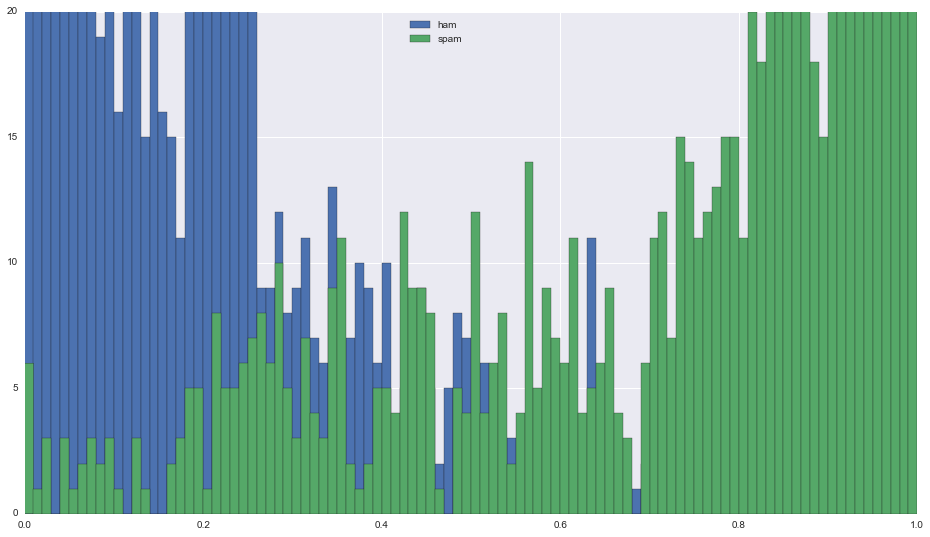

In [47]:
fitted_ham = np.array(spam_glm_step.fittedvalues[~spam_df['TYPE'].astype(bool)])
fitted_spam = np.array(spam_glm_step.fittedvalues[spam_df['TYPE'].astype(bool)])

plt.figure(figsize=(16, 9))
plt.hist(fitted_ham, bins=100, stacked=True, color='b', label="ham") # Ham is blue
plt.hist(fitted_spam, bins=100, stacked=True, color='g', label="spam") # Spam is green
plt.ylim([0, 20]) # Zoom in to try and identify suitable threshold
plt.legend(bbox_to_anchor=(0.5, 1))
plt.show()

The stepwise model on the untransformed data performed unspectacularly. The histogram of fitted values colored by email type shows the worst so far. There is a sizeable overlap in spam and ham emails in probabilities ranging from 0.3 to 0.5.

In [48]:
lspam_glm_step = forward_selected(lspam_df, 'TYPE')
print lspam_glm_step.summary()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   TYPE   No. Observations:                 4601
Model:                            GLM   Df Residuals:                     4577
Model Family:                Binomial   Df Model:                           23
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -729.96
Date:                Wed, 21 Oct 2015   Deviance:                       1459.9
Time:                        19:25:11   Pearson chi2:                 2.20e+04
No. Iterations:                    13                                         
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept          -19.2229      6.710     -2.865      0.004       -32.375    -6.071
CHAR_EXCLAMATION     0.3724      0

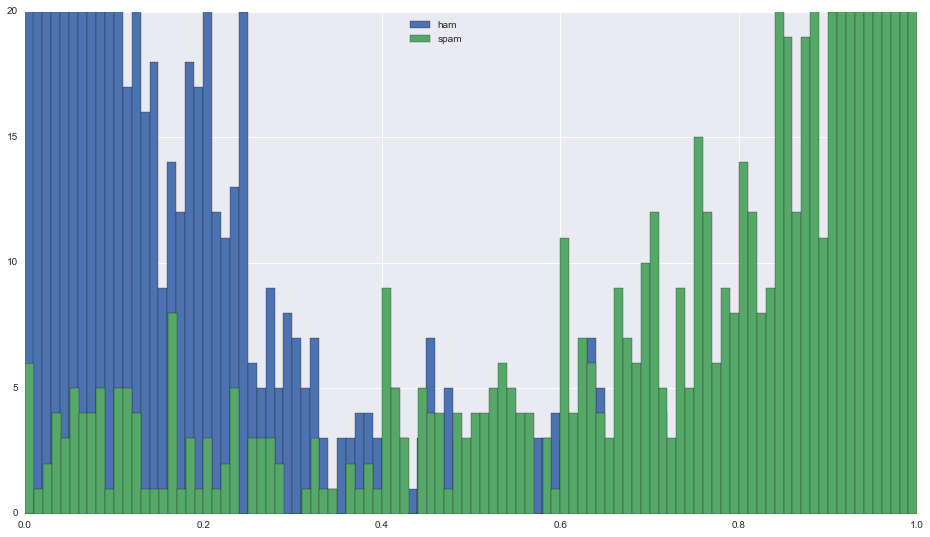

In [49]:
fitted_ham = np.array(lspam_glm_step.fittedvalues[~spam_df['TYPE'].astype(bool)])
fitted_spam = np.array(lspam_glm_step.fittedvalues[spam_df['TYPE'].astype(bool)])

plt.figure(figsize=(16, 9))
plt.hist(fitted_ham, bins=100, stacked=True, color='b', label="ham") # Ham is blue
plt.hist(fitted_spam, bins=100, stacked=True, color='g', label="spam") # Spam is green
plt.ylim([0, 20]) # Zoom in to try and identify suitable threshold
plt.legend(bbox_to_anchor=(0.5, 1))
plt.show()

The log transformed stepwise model performed okay. The ham emails are nearly all less than 0.4 likely of being spam, but numerous spam emails were fitted to probabilities less than 0.4. 

In [50]:
print spam_glm_step.aic
print lspam_glm_step.aic

nan
1507.91134398


In [51]:
print spam_glm_step.bic
print lspam_glm_step.bic

-36650.2166214
-37142.6391609


The log transformed model is the best of all models so far in terms of BIC, but still worse than the main effects log transformed in terms of AIC.

### Model Selection

A few models have been examined so far with varying degrees of success. To determine the effectiveness of the spam filter the data will be split in test and training sets in order to validate filter predictions on unseen data.

In [52]:
# Obtain test and training data sets
spam_df_train, spam_df_test = train_test_split(spam_df, test_size = 0.33, random_state=123)
lspam_df_train, lspam_df_test = train_test_split(lspam_df, test_size = 0.33, random_state=123)

In [53]:
# Verify same elements in both spam and lspam
print np.setdiff1d(spam_df_test.index.values, lspam_df_test.index.values)
print len(np.intersect1d(spam_df_test.index.values, lspam_df_test.index.values)) == len(spam_df_test.index.values)

[]
True


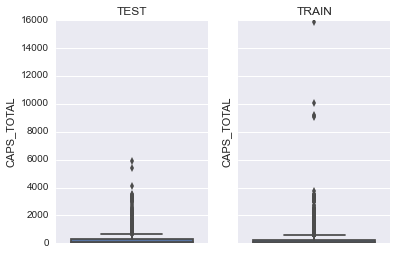

In [54]:
# Check the distributions of the test and training set
ax1 = plt.subplot(121)
sns.boxplot(y='CAPS_TOTAL', data=spam_df_test, ax=ax1)
plt.title('TEST')
ax2 = plt.subplot(122, sharey=ax1)
sns.boxplot(y='CAPS_TOTAL', data=spam_df_train, ax=ax2)
plt.setp( ax2.get_yticklabels(), visible=False)
plt.title('TRAIN')
plt.show()

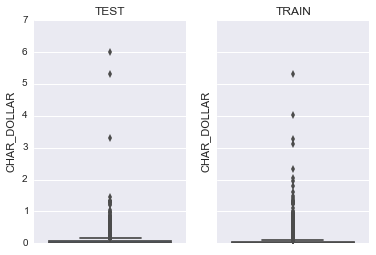

In [55]:
# Check the distributions of the test and training set
ax1 = plt.subplot(121)
sns.boxplot(y='CHAR_DOLLAR', data=spam_df_test, ax=ax1)
plt.title('TEST')
ax2 = plt.subplot(122, sharey=ax1)
sns.boxplot(y='CHAR_DOLLAR', data=spam_df_train, ax=ax2)
plt.setp( ax2.get_yticklabels(), visible=False)
plt.title('TRAIN')
plt.show()

In [56]:
# Proportions of spam, ham
print 'TEST:', len(spam_df_test[spam_df_test['TYPE'] == 0].index)/float(len(spam_df_test.index))*100, \
               len(spam_df_test[spam_df_test['TYPE'] == 1].index)/float(len(spam_df_test.index))*100

print 'TRAIN:', len(spam_df_train[spam_df_train['TYPE'] == 0].index)/float(len(spam_df_train.index))*100, \
                len(spam_df_train[spam_df_train['TYPE'] == 1].index)/float(len(spam_df_train.index))*100

print 'TOTAL:', len(spam_df[spam_df['TYPE'] == 0].index)/float(len(spam_df.index))*100, \
                len(spam_df[spam_df['TYPE'] == 1].index)/float(len(spam_df.index))*100 

TEST: 59.1178406847 40.8821593153
TRAIN: 61.3238157041 38.6761842959
TOTAL: 60.5955227125 39.4044772875


The distributions of spam and ham emails in the test and training sets appear similar enough to proceed.

In [57]:
spam_glm_train = sm_glm('TYPE ~ ' + convert_df_to_patsy_rhs_formula(spam_df.drop('TYPE', axis=1)), 
                         data=spam_df_train, family=sm.families.Binomial()).fit()

spam_glm_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   TYPE   No. Observations:                 3082
Model:                            GLM   Df Residuals:                     3024
Model Family:                Binomial   Df Model:                           57
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Wed, 21 Oct 2015   Deviance:                       1143.2
Time:                        19:26:08   Pearson chi2:                 1.73e+05
No. Iterations:                    32                                         
====================================================================================
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept           -2.1918      0.215    -10.194      0.000        -2.613    -1.770
WORD_MAKE           -0.4978      0.318     -1.564      0.118        -1.122     0.126
WORD_ADDRESS        -0.1645      0.095     -1.732      0.083        -0.351     0.022
WORD_ALL             0.3610      0.160      2.256      0.024         0.047     0.675
WORD_3D              1.5292      1.532      0.998      0.318        -1.474     4.533
WORD_OUR             0.7819      0.154      5.071      0.000         0.480     1.084
WORD_OVER            1.2197      0.372      3.282      0.001         0.491     1.948
WORD_REMOVE          2.8376      0.505      5.620      0.000         1.848     3.827
WORD_INTERNET        0.6912      0.253      2.728      0.006         0.195     1.188
WORD_ORDER           0.4659      0.381      1.224      0.221        -0.280     1.212
WORD_MAIL            0.1242      0.105      1.187      0.235        -0.081     0.329
WORD_RECEIVE        -0.3308      0.378     -0.876      0.381        -1.071     0.410
WORD_WILL           -0.1173      0.098     -1.196      0.232        -0.310     0.075
WORD_PEOPLE         -0.1935      0.309     -0.627      0.531        -0.798     0.411
WORD_REPORT          0.3010      0.238      1.262      0.207        -0.166     0.768
WORD_ADDRESSES       1.4170      0.907      1.562      0.118        -0.360     3.195
WORD_FREE            1.0769      0.209      5.154      0.000         0.667     1.486
WORD_BUSINESS        0.7320      0.267      2.746      0.006         0.210     1.254
WORD_EMAIL           0.2087      0.161      1.293      0.196        -0.108     0.525
WORD_YOU             0.0548      0.045      1.219      0.223        -0.033     0.143
WORD_CREDIT          0.8532      0.543      1.570      0.116        -0.212     1.918
WORD_YOUR            0.1965      0.066      2.973      0.003         0.067     0.326
WORD_FONT           -0.0062      0.207     -0.030      0.976        -0.413     0.400
WORD_000             1.8824      0.570      3.301      0.001         0.765     3.000
WORD_MONEY           0.2055      0.115      1.790      0.073        -0.019     0.430
WORD_HP             -1.5354      0.297     -5.173      0.000        -2.117    -0.954
WORD_HPL            -1.2676      0.488     -2.597      0.009        -2.224    -0.311
WORD_GEORGE        -21.7954      4.656     -4.681      0.000       -30.921   -12.670
WORD_650             0.4135      0.202      2.043      0.041         0.017     0.810
WORD_LAB            -2.6752      1.789     -1.496      0.135        -6.181     0.830
WORD_LABS           -0.2744      0.338     -0.811      0.417        -0.937     0.389
WORD_TELNET         -0.1095      0.320     -0.342      0.732        -0.737     0.518
WORD_857            16.7500     92.327      0.181      0.856      -164.207   197.707
WORD_DATA           -0.9016      0.406     -2.222      0.026        -1.697    -0.106
WORD_415         

In [58]:
lspam_glm_train = sm_glm('TYPE ~ ' + convert_df_to_patsy_rhs_formula(lspam_df.drop('TYPE', axis=1)), 
                         data=lspam_df_train, family=sm.families.Binomial()).fit()

lspam_glm_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   TYPE   No. Observations:                 3082
Model:                            GLM   Df Residuals:                     3024
Model Family:                Binomial   Df Model:                           57
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -454.92
Date:                Wed, 21 Oct 2015   Deviance:                       909.83
Time:                        19:26:09   Pearson chi2:                 2.25e+04
No. Iterations:                    27                                         
====================================================================================
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept          -76.5906   9.99e+04     -0.001      0.999     -1.96e+05  1.96e+05
WORD_MAKE           -0.2067      0.075     -2.742      0.006        -0.354    -0.059
WORD_ADDRESS        -0.0389      0.064     -0.608      0.543        -0.164     0.087
WORD_ALL            -0.0698      0.054     -1.299      0.194        -0.175     0.035
WORD_3D              0.0064      0.210      0.031      0.976        -0.405     0.418
WORD_OUR             0.2661      0.051      5.240      0.000         0.167     0.366
WORD_OVER            0.1242      0.072      1.733      0.083        -0.016     0.265
WORD_REMOVE          0.5347      0.083      6.472      0.000         0.373     0.697
WORD_INTERNET        0.1821      0.080      2.285      0.022         0.026     0.338
WORD_ORDER           0.0102      0.087      0.117      0.907        -0.161     0.181
WORD_MAIL           -0.0104      0.056     -0.187      0.851        -0.119     0.098
WORD_RECEIVE        -0.0101      0.086     -0.117      0.907        -0.178     0.158
WORD_WILL           -0.1149      0.044     -2.588      0.010        -0.202    -0.028
WORD_PEOPLE         -0.2291      0.080     -2.864      0.004        -0.386    -0.072
WORD_REPORT          0.2241      0.104      2.150      0.032         0.020     0.428
WORD_ADDRESSES       0.2275      0.184      1.237      0.216        -0.133     0.588
WORD_FREE            0.3036      0.054      5.573      0.000         0.197     0.410
WORD_BUSINESS        0.2227      0.071      3.148      0.002         0.084     0.361
WORD_EMAIL          -0.1138      0.063     -1.803      0.071        -0.238     0.010
WORD_YOU            -0.0210      0.045     -0.471      0.638        -0.108     0.066
WORD_CREDIT          0.1974      0.120      1.644      0.100        -0.038     0.433
WORD_YOUR            0.1416      0.046      3.110      0.002         0.052     0.231
WORD_FONT           -0.0068      0.103     -0.066      0.948        -0.210     0.196
WORD_000             0.2253      0.102      2.213      0.027         0.026     0.425
WORD_MONEY           0.2941      0.087      3.389      0.001         0.124     0.464
WORD_HP             -0.6972      0.096     -7.265      0.000        -0.885    -0.509
WORD_HPL            -0.0993      0.105     -0.944      0.345        -0.306     0.107
WORD_GEORGE         -1.7294      0.304     -5.682      0.000        -2.326    -1.133
WORD_650             0.3893      0.100      3.903      0.000         0.194     0.585
WORD_LAB            -0.3103      0.183     -1.692      0.091        -0.670     0.049
WORD_LABS           -0.0243      0.125     -0.194      0.846        -0.270     0.221
WORD_TELNET         -0.1215      0.296     -0.411      0.681        -0.701     0.458
WORD_857             0.2382      1.678      0.142      0.887        -3.050     3.527
WORD_DATA           -0.1361      0.096     -1.416      0.157        -0.325     0.052
WORD_415         

In [59]:
spam_glm_train_step = forward_selected(spam_df_train, 'TYPE')
print spam_glm_train_step.summary()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   TYPE   No. Observations:                 3082
Model:                            GLM   Df Residuals:                     3057
Model Family:                Binomial   Df Model:                           24
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Wed, 21 Oct 2015   Deviance:                       1228.8
Time:                        19:28:08   Pearson chi2:                 2.11e+05
No. Iterations:                    32                                         
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept           -2.1537      0.163    -13.249      0.000        -2.472    -1.835
CHAR_DOLLAR          5.0779      0

In [60]:
lspam_glm_train_step = forward_selected(lspam_df_train, 'TYPE')
print lspam_glm_train_step.summary()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   TYPE   No. Observations:                 3082
Model:                            GLM   Df Residuals:                     3058
Model Family:                Binomial   Df Model:                           23
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -492.43
Date:                Wed, 21 Oct 2015   Deviance:                       984.86
Time:                        19:29:25   Pearson chi2:                 3.25e+04
No. Iterations:                    27                                         
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept          -71.2797   1.04e+05     -0.001      0.999     -2.04e+05  2.03e+05
CHAR_EXCLAMATION     0.3530      0

In [61]:
# Predict on the test set
spam_predict = spam_glm_train.predict(spam_df_test.to_records())
spam_step_predict = spam_glm_train_step.predict(spam_df_test.to_records())

lspam_predict = lspam_glm_train.predict(lspam_df_test.to_records())
lspam_step_predict = lspam_glm_train_step.predict(lspam_df_test.to_records())

In [62]:
# Define a function to apply a threshold of choosing for the fitted values
def thresh_array(values, thresh):
    output = []
    for value in values:
        if value >= thresh:
            output.append(1)
        else:
            output.append(0)

    return output

In [63]:
# See: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
#
# [[ true pos, false pos],
#  [false neg,  true neg]]

# Evalute spam main effects at different thresholds
print confusion_matrix(spam_df_test.TYPE, thresh_array(spam_predict, 0.4)), '\n'
print confusion_matrix(spam_df_test.TYPE, thresh_array(spam_predict, 0.5)), '\n'
print confusion_matrix(spam_df_test.TYPE, thresh_array(spam_predict, 0.6))

[[814  84]
 [ 48 573]] 

[[836  62]
 [ 61 560]] 

[[847  51]
 [ 79 542]]


In [64]:
# Evalute lspam main effects at different thresholds
print confusion_matrix(lspam_df_test.TYPE, thresh_array(lspam_predict, 0.4)), '\n'
print confusion_matrix(lspam_df_test.TYPE, thresh_array(lspam_predict, 0.5)), '\n'
print confusion_matrix(lspam_df_test.TYPE, thresh_array(lspam_predict, 0.6))

[[847  51]
 [ 38 583]] 

[[854  44]
 [ 49 572]] 

[[860  38]
 [ 64 557]]


In [65]:
# Evalute spam_step main effects at different thresholds
print confusion_matrix(spam_df_test.TYPE, thresh_array(spam_step_predict, 0.4)), '\n'
print confusion_matrix(spam_df_test.TYPE, thresh_array(spam_step_predict, 0.5)), '\n'
print confusion_matrix(spam_df_test.TYPE, thresh_array(spam_step_predict, 0.6))

[[824  74]
 [ 52 569]] 

[[839  59]
 [ 71 550]] 

[[847  51]
 [ 95 526]]


In [66]:
# Evalute lspam_step main effects at different thresholds
print confusion_matrix(lspam_df_test.TYPE, thresh_array(lspam_step_predict, 0.4)), '\n'
print confusion_matrix(lspam_df_test.TYPE, thresh_array(lspam_step_predict, 0.5)), '\n'
print confusion_matrix(lspam_df_test.TYPE, thresh_array(lspam_step_predict, 0.6))

[[841  57]
 [ 39 582]] 

[[857  41]
 [ 50 571]] 

[[864  34]
 [ 64 557]]


The confusion matrices for each of the four models shows the log transformed main effects had the lowest number of errors, false positives plus false negatives, for the 0.4 threshold while the stepwise log transform had the lowest number for both 0.5 and 0.6. Any fitted values above or equal to the threshold were labeled spam otherwise the email was labeled ham. False positives indicate the email was predicted to be spam when in truth it was spam. Conversely, emails predicted  ham when in fact are spam are false negatives.

In [67]:
#  Receiver operating characteristic (ROC) Curves
me_fpr, me_tpr, _ = roc_curve(spam_df_test.TYPE, spam_predict, 1)
lme_fpr, lme_tpr, lme_thresh = roc_curve(lspam_df_test.TYPE, lspam_predict, 1)
s_fpr, s_tpr, _ = roc_curve(spam_df_test.TYPE, spam_step_predict, 1)
ls_fpr, ls_tpr, _ = roc_curve(lspam_df_test.TYPE, lspam_step_predict, 1)

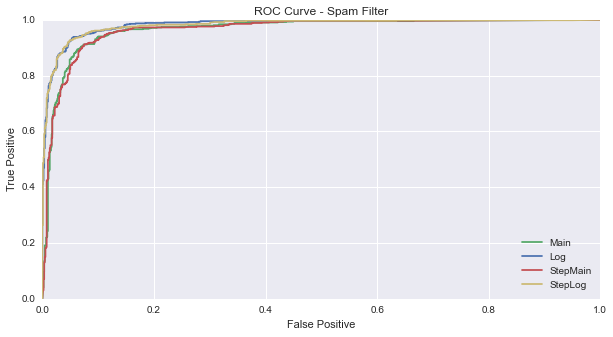

In [68]:
plt.figure(figsize=(10, 5))
plt.plot(me_fpr, me_tpr, 'g', label='Main')
plt.plot(lme_fpr, lme_tpr, 'b', label='Log')
plt.plot(s_fpr, s_tpr, 'r', label='StepMain')
plt.plot(ls_fpr, ls_tpr, 'y', label='StepLog')

plt.legend(loc=4)
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC Curve - Spam Filter')

plt.show()

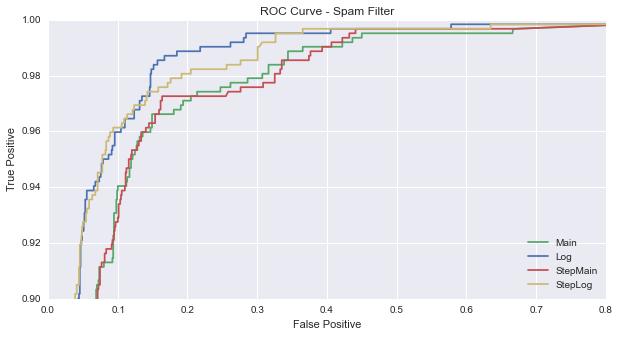

In [69]:
plt.figure(figsize=(10, 5))
plt.plot(me_fpr, me_tpr, 'g', label='Main')
plt.plot(lme_fpr, lme_tpr, 'b', label='Log')
plt.plot(s_fpr, s_tpr, 'r', label='StepMain')
plt.plot(ls_fpr, ls_tpr, 'y', label='StepLog')

# Zoom on top
plt.xlim([0, 0.8])
plt.ylim([0.9, 1])

plt.legend(loc=4)
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC Curve - Spam Filter')

plt.show()

The receiver operating characteristic (ROC) curves show the log transformed models performed better in terms of true positive and false positive rates than their untransformed counterparts. The log transformed main effects model seems to be the bestas its ROC curve is the same or better than the step log model over all threhold values.

In [70]:
# Identify best threshold for log model based on lowest number of errors
best_thresh = 0.5
lowest_num_errors = 999

num_test_points = len(lme_fpr)
num_test_spam = len(lspam_df_test[lspam_df_test['TYPE'] == 0].index)
num_test_ham = len(lspam_df_test[lspam_df_test['TYPE'] == 1].index)

for ii in xrange(num_test_points):
    val = (lme_fpr[ii]*num_test_spam) + ((1-lme_tpr[ii])*num_test_ham)
    if val < lowest_num_errors:
        lowest_num_errors = val
        best_thresh = lme_thresh[ii]
           
print lowest_num_errors, best_thresh
print confusion_matrix(lspam_df_test.TYPE, thresh_array(lspam_predict, best_thresh))

88.0 0.433980452988
[[850  48]
 [ 40 581]]


In [71]:
# Identify best threshold for log model based on maximum of 0.5% false positive rate
# Don't want any real emails to end up in spam folder.
best_true_pos = 0
for ii in xrange(num_test_points):
    if lme_fpr[ii] < 0.005 and lme_tpr[ii] > best_true_pos:
        best_true_pos = lme_tpr[ii]
        best_thresh = lme_thresh[ii]
           
print best_true_pos, best_thresh
print confusion_matrix(lspam_df_test.TYPE, thresh_array(lspam_predict, best_thresh))

0.579710144928 0.979462758694
[[894   4]
 [261 360]]


In [72]:
# Identify best threshold for log model based on maximum of 0.5% false negative rate
# Don't want any spam emails in real email folder
best_false_pos = 123123
for ii in xrange(num_test_points):
    if lme_tpr[ii] > 0.995 and lme_fpr[ii] < best_false_pos:
        best_false_pos = lme_fpr[ii]
        best_thresh = lme_thresh[ii]
           
print best_false_pos, best_thresh
print confusion_matrix(lspam_df_test.TYPE, thresh_array(lspam_predict, best_thresh))

0.283964365256 0.0353619162783
[[643 255]
 [  3 618]]


Some sensitivity analysis of various thresholds reveals being very picky about classifying ham or spam will significantly increase the number of errors in the spam filter. Using the optimal threshold found of 0.444 an error rate of 5.8% was achieved (3.2% flase positive, 2.6% false negative) by the filter. Restricting the maximum allowed false positive rate to 0.5% increased the false negative rate to 17.2%. Similarly resctricting the maximum allowed false negative rate to 0.5% increased the false positive rate to 16.8%.

# 4 Recommendation

Past usage of this data set by Hewlett-Packard has previously identified a model with an approximately 7% misclassification error rate [9]. The log transformed main effects model identified in Section 3 was able to find a threshold of 0.444 to achieve around a 6% misclassification rate. If reducing false positives (marking good email as spam) is desirable then around 40% of all spam will make it into your inbox. A threshold can be configured to help identify a user's tolerance for reducing the number of good emails marked as spam versus allowing spam emails through. Additional data and keywords may help improve the model as well as increase customization for a specific user. For example, in this data set the word george was very specific to the curator of the data, but the name may differ for another email user. This study also found the presence of a coefficient for number of capital letters in the model was found to be significant at the 0.01 level. 

# 5 References

\[1\] Jones E, Oliphant E, Peterson P, et al. SciPy: Open Source Scientific Tools for Python, 2001-, http://www.scipy.org/ [Online; accessed 2015-10-20]

\[2\] [Scikit-learn: Machine Learning in Python](http://jmlr.csail.mit.edu/papers/v12/pedregosa11a.html), Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

\[3\] M. Waskom, [Seaborn](http://stanford.edu/~mwaskom/software/seaborn/). 2015.

\[4\] [Biboroko](http://okomestudio.net/biboroku/?p=2292) 

\[5\] Forward Selected code modified from original at PlanSpace (http://planspace.org/20150423-forward_selection_with_statsmodels/)

\[6\] J. Rao and D. Reiley, 'The Economics of Spam', Journal of Economic Perspectives, vol. 26, no. 3, pp. 87-110, 2012.

\[7\] D. E. Brown "Homework 4: Spam filters," October 2015, assignment in class APMA 6430.

\[8\] D. E. Brown, "Homework 4 template: Spam filter," Januarary 2014, template for Homework 4 in class APMA 6430.

\[9\] Lichman, M. (2013). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

\[10\] Data.princeton.edu, 'WWS 509', 2015. [Online]. Available: http://data.princeton.edu/wws509/notes/c3s1.html. [Accessed: 21- Oct- 2015].